In [ ]:
# Импортируем базовые библиотеки для анализа данных и линейной алгебры
import numpy as np  # Линейная алгебра
import pandas as pd  # Обработка и чтение данных

# Библиотеки для работы с текстами и геопозицией
from textblob import TextBlob  # Анализ тональности текста
from geopy.distance import great_circle  # Расчёт расстояний на основе координат

# Инструменты для машинного обучения
from sklearn.ensemble import RandomForestRegressor  # Алгоритм случайного леса для регрессии
from sklearn import metrics  # Метрики для оценки качества модели
from sklearn.model_selection import train_test_split  # Разделение данных на тренировочные и тестовые наборы
from sklearn.feature_selection import chi2, f_classif  # Методы отбора признаков

# Статистические библиотеки
import statsmodels.api as sm  # Пакет для статистического моделирования
from statsmodels import stats as sms  # Дополнительные статистические функции
import re  # Работа с регулярными выражениями
import sklearn  # Основные модули библиотеки scikit-learn
import category_encoders as ce  # Кодировщики категорий
from scipy import stats  # Статистический пакет SciPy

# Библиотеки для визуализации данных
import matplotlib.pyplot as plt  # Основной модуль для построения графиков
import seaborn as sns # Библиотека для красивой визуализации данных

%matplotlib inline

# Настраиваем тему и палитру для Seaborn
sns.set_theme('notebook')
sns.set_palette('PiYG')

# Импортируем коллекцию Counter для подсчета элементов
from collections import Counter

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [ ]:
# Подгрузим наши данные

df_train = pd.read_csv('hotels_train.csv', encoding='latin1') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv', encoding='latin1') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv') # самбмишн

# Подгрузим дополнительные данные для прогнозирования
city_centre = pd.read_csv('city_centre.csv') # Координаты центральных точек городов
name_of_countries = pd.read_csv('name_of_countries.csv') # Название локаций и частей света для каждой страны

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [10]:
sample_submission.head(15)

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
5,10,302161
6,10,317079
7,1,13963
8,4,159785
9,10,195089


In [11]:
city_centre.head()

,city,lat,lng
0,London,51.489334,-0.144055
1,Paris,48.853495,2.348391
2,Rome,41.893320,12.482932
3,Berlin,52.510885,13.398937
4,Madrid,40.416705,-3.703582


In [12]:
name_of_countries.head()

,name,fullname,english,alpha2,alpha3,iso,location,location-precise
0,Наименование,Полное наименование,На английском,Alpha2,Alpha3,ISO,Часть света,Расположение
1,Абхазия,Республика Абхазия,Abkhazia,AB,ABH,895,Азия,Закавказье
2,Австралия,,Australia,AU,AUS,036,Океания,Австралия и Новая Зеландия
3,Австрия,Австрийская Республика,Austria,AT,AUT,040,Европа,Западная Европа
4,Азербайджан,Республика Азербайджан,Azerbaijan,AZ,AZE,031,Азия,Западная Азия


In [13]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

# Объединяем train и test датасеты с помощью concat
data = pd.concat([df_train, df_test], ignore_index=True, sort=False)

# Подготовительный этап

**1. Для проведения статистического анализа нам понадобятся следующие функции:**

In [14]:
# Устанавливаем уровень значимости
alpha = 0.05

# Функция для принятия решения о нормальности распределения
def decision_normality(p):
    """
    Функция выводит решение о нормальности распределения на основе p-значения.

    Параметры:
    p (float): p-значение, полученное из теста на нормальность.
    """
    print(f'p-value = {p:.3f}')
    if p <= alpha:
        print(f'p-значение меньше, чем заданный уровень значимости {alpha:.2f}. '
              f'Распределение отлично от нормального.')
    else:
        print(f'p-значение больше, чем заданный уровень значимости {alpha:.2f}. '
              f'Распределение является нормальным.')

# Функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    """
    Функция выводит решение о нулевой гипотезе на основе p-значения.

    Параметры:
    p (float): p-значение, полученное из статистического теста.
    """
    print(f'p-value = {p:.3f}')
    if p <= alpha:
        print(f'p-значение меньше, чем заданный уровень значимости {alpha:.2f}. '
              f'Отвергаем нулевую гипотезу в пользу альтернативной.')
    else:
        print(f'p-значение больше, чем заданный уровень значимости {alpha:.2f}. '
              f'У нас нет оснований отвергнуть нулевую гипотезу.')

In [15]:
def stat_test(test, groups, alt='two-sided'):
    """
    Функция проводит выбранный статистический тест и возвращает решение о гипотезе.

    Параметры:
    test (str): Название теста ('mannwhitneyu', 'sign_test', 'wilcoxon', 'kruskal', 'friedman').
    groups (tuple of array-like): Наборы данных для тестирования.
    alt (str, optional): Альтернатива для одностороннего или двустороннего теста. По умолчанию 'two-sided'.

    Возвращает:
    str: Решение о нулевой гипотезе.
    """
    if test == 'mannwhitneyu':
        _, p = stats.mannwhitneyu(*groups, alternative=alt)
    elif test == 'sign_test':
        _, p = stats.descriptivestats.sign_test(*groups, alternative=alt)
    elif test == 'wilcoxon':
        _, p = stats.wilcoxon(*groups, alternative=alt)
    elif test == 'kruskal':
        _, p = stats.kruskal(*groups)
    elif test == 'friedman':
        _, p = stats.friedmanchisquare(*groups, alternative=alt)
    return decision_hypothesis(p)

In [16]:
def shapiro(group, i):
    """
    Проводит тест Шапиро-Уилка для проверки нормальности распределения в группе.

    Параметры:
    group (array-like): Группа данных, которую необходимо проверить на нормальность.
    i (int): Номер группы для вывода информации.

    Возвращает:
    None: Функция не возвращает значение, но выводит результаты теста и решение о нормальности.
    """
    # Выводим номер группы
    print(f'Группа {i}: ')

    # Выполняем тест Шапиро-Уилка
    result = stats.shapiro(group)

    # Передаем p-значение в функцию для принятия решения о нормальности
    decision_normality(result[1])

Так как у нас большие выборки, значимость эффекта также будем проверять коэффициентом Клайна. 
Чтобы оценить насколько сильно группы отличаются друг от друга

In [17]:
def cohens(group1, group2):
    """
    Функция рассчитывает коэффициент Клайна (Cohen's d) между двумя группами данных.

    Параметры:
    group1 (array-like): Первая группа данных.
    group2 (array-like): Вторая группа данных.

    Возвращает:
    str: Строка с результатом расчета коэффициента Клайна и уровнем эффекта.
    """
    # Рассчитаем медианы обеих групп
    median1 = np.median(group1)
    median2 = np.median(group2)

    # Рассчитаем разницу медиан
    median_diff = median1 - median2

    # Рассчитаем объединенную дисперсию для непараметрического Cohen's d
    pooled_std = np.sqrt((np.var(group1, ddof=1) + np.var(group2, ddof=1)) / 2)

    # Рассчитаем Cohen's d
    cohens_d = abs(median_diff / pooled_std)

    # Определим уровень эффекта на основе значения Cohen's d
    if cohens_d < 0.2:
        level = 'незначительный'
    elif 0.2 <= cohens_d < 0.4:
        level = 'малый'
    elif 0.4 <= cohens_d < 0.6:
        level = 'средний'
    elif 0.6 <= cohens_d < 0.8:
        level = 'большой'
    else:
        level = 'очень большой'

    # Формируем результат в виде строки
    result = f"Cohen's d: {round(cohens_d, 1)}, уровень эффекта: {level}"

    return result

Чтобы визуально оценить распределение групп, которые сравниваем. Создадим для визуализации функцию 

In [18]:
def distribution(group1, group2):
    """
    Функция строит гистограммы распределения двух групп данных.

    Параметры:
    group1 (array-like): Первая группа данных.
    group2 (array-like): Вторая группа данных.
    """
    # Создаем фигуру с двумя подграфиками
    fig, axes = plt.subplots(1, 2, figsize=(10, 2))

    # Строим гистограмму для первой группы данных
    axes[0].hist(group1, bins=30, density=True)
    axes[0].set_title("group1")  

    # Строим гистограмму для второй группы данных
    axes[1].hist(group2, bins=30, density=True)
    axes[1].set_title('group2')  

    plt.tight_layout()  

In [19]:
def pie_bar(name, title, x_name):
    """
    Функция строит круговую диаграмму и барплот для заданного признака.

    Параметры:
    name (str): Имя столбца данных, который нужно визуализировать.
    title (str): Заголовок графика.
    x_name (str): Название оси X для барплота.
    """
    # Создаем фигуру с двумя подграфиками
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Считаем количество значений для каждого уникального значения в столбце 'name'
    counts = data[data['sample'] == 1][name].value_counts()

    # Строим круговую диаграмму
    axes[0].pie(
        counts,          
        labels=counts.index,  
        startangle=90,      
        autopct='%1.f%%',    
    )
    axes[0].set_title(title)     

    # Группируем данные по значению 'name' и вычисляем медиану оценки
    group = data[data['sample'] == 1].groupby(name)['reviewer_score'].median().reset_index()

    # Строим барплот для признака
    sns.barplot(
        x=group[name],     
        y=group['reviewer_score'],  
        ax=axes[1]          
    )
    axes[1].set_title(title)    
    axes[1].set_xlabel(x_name) 
    axes[1].set_ylabel('Оценка')
    plt.tight_layout()          

Создадим переменную в которую будем добавлять признаки, которые статистически важны и которые будем использовать в обучении модели.

In [20]:
cat_col = ['sample']
num_col = ['reviewer_score']

# Знакомство с данными

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [22]:
data[['average_score', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 
      'reviewer_score', 'total_number_of_reviews_reviewer_has_given', 'total_number_of_reviews',
      'lat', 'lng']].describe()

,average_score,review_total_negative_word_counts,review_total_positive_word_counts,reviewer_score,total_number_of_reviews_reviewer_has_given,total_number_of_reviews,lat,lng
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000
mean,8.397487,18.539450,17.776458,6.297672,7.166001,2743.743944,49.442439,2.823803
std,0.548048,29.690831,21.804185,3.902295,11.040228,2317.464868,3.466325,4.579425
min,5.200000,0.000000,0.000000,0.000000,1.000000,43.000000,41.328376,-0.369758
25%,8.100000,2.000000,5.000000,0.625000,1.000000,1161.000000,48.214662,-0.143372
50%,8.400000,9.000000,11.000000,7.900000,3.000000,2134.000000,51.499981,0.010607
75%,8.800000,23.000000,22.000000,9.600000,8.000000,3613.000000,51.516288,4.834443
max,9.800000,408.000000,395.000000,10.000000,355.000000,16670.000000,52.400181,16.429233


1. Максимальный средний бал за год достигал 9.8, а минимальный 8.3. 
2. Среди негативных отзывов были очень содержательные (408 слов), так и пустые отзывы. Но в среднем отзыв содержал около 18 слов. По положительным отзывам имеем похожую картину.
3. Средний бал, который сиавили рецензенты ниже среднего бала загод по отелям. максимальный бал, который ставили рецензенты, составил 10, а минимальный - 0. Это говорит о том, что в данных имеются отзывы, где пользователь не проставил свою оценку.
4. В данных есть как очень опытные рецензенты, которые оставили в прошлом более 300 отзывов, так и новички, кто оставил свой первый отзыв. В среднем каждый пользователь оставлял не более 7 отзыаов.
5. У нас имеются пропуски в признаках долготы и широты, что говорит о том, что в данных некорректно заполнены адреса.

In [23]:
print(f'Пропусков в датафрейме в признаках lat и lng {data[(data.lat.isna()) | (data.lng.isna())].shape[0]}')
print(f"Из пропущенных значений, для {data[data.lat.isna()]['hotel_address'].unique().shape[0]} адресов нет данных о долготе и широте")

Пропусков в датафрейме в признаках lat и lng 3268
Из пропущенных значений, для 17 адресов нет данных о долготе и широте


In [24]:
data[data.lat.isna()]['hotel_address'].unique()

array(['Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
       '23 Rue Damr mont 18th arr 75018 Paris France',
       'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
       'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria',
       '4 rue de la P pini re 8th arr 75008 Paris France',
       'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
       'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
       'Bail n 4 6 Eixample 08010 Barcelona Spain',
       'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
       'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
       'Paragonstra e 1 11 Simmering 1110 Vienna Austria',
       'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
       '20 Rue De La Ga t 14th arr 75014 Paris France',
       'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
       'Sep lveda 180 Eixample 08011 Barcelona Spain',
       'Pau Clar s 122 Eixample 08009 Barcelona Spain',
       'Josefst dter Stra e 22 08 Jos

В адресах, в которых пропущены значения долготы и широты, допущены ошибки. Это могло случится при сборе данных, некоторые адреса имеют символы, которых нет в английском алфавите. 
Адресов с пропусками совсем немного, поэтому вручную соберем данные о долготе и широте. Заполним пропуски в следующем разделе исследования.

In [25]:
data[['hotel_name', 'review_date', 'hotel_address', 'reviewer_nationality', 'negative_review',
      'positive_review', 'tags', 'days_since_review']].describe(include='object')

,hotel_name,review_date,hotel_address,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,515738,515738,515738,515738,515738,515738,515738,515738
unique,1492,731,1493,227,330011,412601,55242,731
top,Britannia International Hotel Canary Wharf,8/2/2017,163 Marsh Wall Docklands Tower Hamlets London ...,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,4789,2585,4789,245246,127890,35946,5101,2585


1. В данных 1492 уникальных отеля. Britannia International Hotel Canary Wharf - самый популярный отель в данных, о нем имеется 4789 записей.
2. Больше всего отзывов за февраля 2017 года.
3. Мы имеем 1493 уникальных адреса, что говорит о том, что в данных есть отель с одинаковым названием, но с разными адресами.
4. Половина отзывов написана людьми из United Kingdom. Всего в данных встречаются 227 уникальных стран, проживания рецензентов.
5. Среди отзывов лидируют 'No positive', 'No negative'. Без негатива отзывла больше.
6. Есть 55242 уникальных комбинаций тегов.
7. В данных имеются как свежие отзывы, после проверки которых прошел только 1 день. Так и более старые.

# Работа с пропусками

## **1. Заполним пропущенные значения (lat, lng)**

In [26]:
# Вручную собираем данные о долготе и широте пропущенных данных и записываем в список.
coordinates = [
    ('W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria', 48.220301, 16.357513),
    ('Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria', 48.225182, 16.358573),
    ('23 Rue Damr mont 18th arr 75018 Paris France', 48.856663, 2.351556),
    ('Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria', 48.210918, 16.347119),
    ('Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria', 48.218213, 16.394110),
    ('Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria', 48.210918, 16.347119),  
    ('Bail n 4 6 Eixample 08010 Barcelona Spain', 41.391194, 2.155134),
    ('Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria', 48.199420, 16.338610), 
    ('4 rue de la P pini re 8th arr 75008 Paris France', 48.856663, 2.351556),
    ('20 Rue De La Ga t 14th arr 75014 Paris France', 48.838331, 2.330948),
    ('W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria', 48.220720, 16.352360),
    ('Savoyenstra e 2 16 Ottakring 1160 Vienna Austria', 48.211969, 16.311241), 
    ('Pau Clar s 122 Eixample 08009 Barcelona Spain', 41.504994, 2.245959),
    ('Sieveringer Stra e 4 19 D bling 1190 Vienna Austria', 48.245935, 16.341397),
    ('Paragonstra e 1 11 Simmering 1110 Vienna Austria', 48.176599, 16.413999),
    ('Hasenauerstra e 12 19 D bling 1190 Vienna Austria', 48.233495, 16.345556),
    ('Sep lveda 180 Eixample 08011 Barcelona Spain', 41.379389, 2.157475)]

# Заполняем датафрейм значениями из списка
for addr, lat, lng in coordinates:
    data.loc[data['hotel_address'] == addr, 'lat'] = lat
    data.loc[data['hotel_address'] == addr, 'lng'] = lng

# Предобработка данных

In [27]:
# Сначала уберем лишние пробелы в признаке reviewer_nationality
data.reviewer_nationality = data.reviewer_nationality.str.strip()

In [28]:
# Вытаскиваем только числовое значение дней
data.days_since_review = data['days_since_review'].apply(lambda x: int(x.split()[0]))

Признаки 'review_total_positive_word_counts' и 'review_total_negative_word_counts' имели явные ошибки. Считали лишние пробелы вместо слов. Исправим эти признаки

In [29]:
# Приводим к нижнему регистру, разделяем на слова и удаляем лишние слова в пробелах. Считаем количество слов, если они не равны no negative
data['review_total_negative_word_counts'] = data.negative_review.str.split().apply(
                                                lambda x: len([word.strip() for word in x]) if x != 'no negative'  else 0
                                            )

In [30]:
# Приводим к нижнему регистру, разделяем на слова и удаляем лишние слова в пробелах. Считаем количество слов, если они не равны no positive
data['review_total_positive_word_counts'] = data.positive_review.str.split().apply(
                                                lambda x: len([word.strip() for word in x]) if x != 'no positive' else 0
                                            )

In [31]:
num_col.extend(['review_total_positive_word_counts', 'review_total_negative_word_counts'])

In [32]:
# Уберем лишние пробелы и приведем к единому регистру негативные отзывы
data.negative_review = data.negative_review.str.lower().str.strip()

# Уберем лишние пробелы и приведем к единому регистру положительные отзывы
data.positive_review = data.positive_review.str.lower().str.strip()

# Работа с признаками

## Работа с датой

In [33]:
# Преобразуем строку даты в формат datetime
data['review_date'] = pd.to_datetime(data['review_date'])

# Извлекаем месяц из поля review_date и сохраняем в новый столбец month_review
data['month_review'] = data['review_date'].dt.month

# Извлекаем год из поля review_date и сохраняем в новый столбец year_review
data['year_review'] = data['review_date'].dt.year

# Извлекаем номер недели по ISO-календарю из поля review_date и сохраняем в новый столбец week_number
data['week_number'] = data['review_date'].dt.isocalendar().week

data['q_number'] = data['review_date'].dt.quarter

## Работа с hotel_address

In [34]:
# Извлекаем город, в котором находится отель
data['hotel_city'] = data['hotel_address'].apply(lambda x: x.split()[-5] if 'United Kingdom' in x else x.split()[-2])

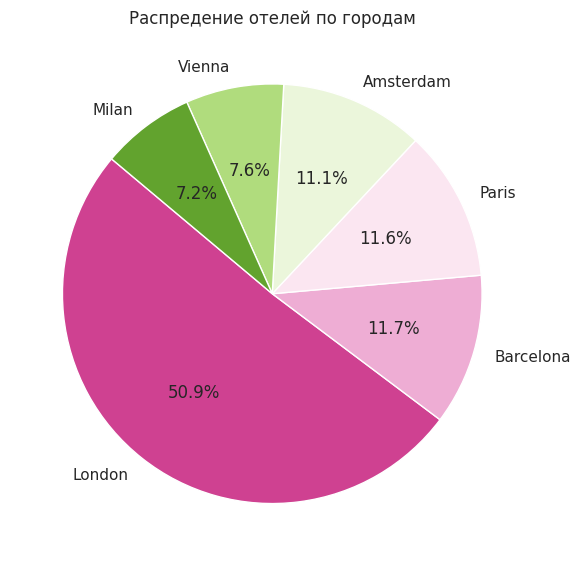

In [35]:
# Смотрим распределение отелей по городам
fig, axes = plt.subplots(figsize=(6, 6))
city_counts = data.hotel_city.value_counts()

plt.pie(
    city_counts,
    labels = city_counts.index,
    autopct='%1.1f%%',
    startangle=140
);

plt.title("Распредение отелей по городам")
plt.tight_layout()

Половину наших данных составляют отели, находящиеся в Лондоне. Остальные города имеют приблизительно одинаковое количество данных.

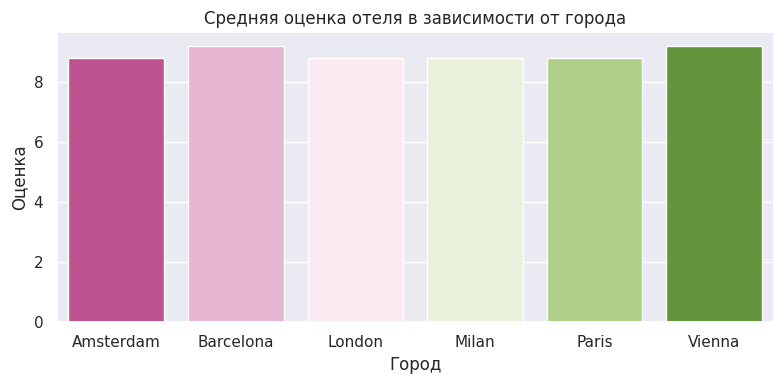

In [36]:
fig, axes = plt.subplots(figsize=(8, 4))

# Группируем по названию отеля и расчитываем медианную оценку
city_score = data[data['sample'] == 1].groupby('hotel_city')['reviewer_score'].median().reset_index()

# Строим барплот
sns.barplot(
    x=city_score.hotel_city, 
    y=city_score['reviewer_score'])

plt.title('Средняя оценка отеля в зависимости от города')
plt.xlabel('Город')
plt.ylabel('Оценка')
plt.tight_layout();

Во всех городах из данных примерно одинаковый средний уровень оценок отелей.
Но у отелей из Барселоны и Вены прослеживаются более высокие оценки. Давайте установим является ли это предположение статистически важным.

**Нулевая гипотеза:** У отелей из Барселоны и Вены оценки равны или ниже оценкам остальных отелей.

**Альтернативная гипотеза:** У отелей из Барселоны и Вены оценки выше, чем у остальных отелей.

1. Выделим группы
2. Проверим распределение 
3. Выберем тест и проведем его.

In [37]:
# Выделяем группы для сравнения 
bars_v = data.loc[(data['sample'] == 1) & (data['hotel_city'].isin(['Barselona', 'Vienna'])), 'reviewer_score']
other_city = data.loc[(data['sample'] == 1) & (~data['hotel_city'].isin(['Barselona', 'Vienna'])), 'reviewer_score']

# Проверяем нормальность распределения
shapiro(bars_v, 1)
shapiro(other_city, 2)

Группа 1: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 2: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 29178.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 357625.
  res = hypotest_fun_out(*samples, **kwds)


In [38]:
# 2 группы, независимы, количественный признак, проводим тест Манна-Уитни
stat_test('mannwhitneyu', [bars_v, other_city], alt='greater')

# считаем коэффициент Клайна для количественной оценки разницы между 2 группами
cohens(bars_v, other_city)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


"Cohen's d: 0.3, уровень эффекта: малый"

Различия в оценках очень небольшие, но всеже оставим этот признак для работы. 

* **Создадим признак 'hotel_country', чтобы знать страну, в который находится отель**

In [39]:
data['hotel_country'] = data['hotel_address'].apply(lambda x: ' '.join(x.split()[-2:]) if 'United Kingdom' in x else x.split()[-1])

  * **Вытащим индекс каждого города и создадим новый признак с индексом.**

In [40]:
# функция для извдечения индекса из адреса в зависимости от города
def postal_codes(city, address):
    if city in ['Milan', 'Barcelona', 'Paris', 'Vienna']:
        return address.split()[-3]
    else:
        return ' '.join(address.split()[-4:-2])

# Создаем новый признак с индексом, применив функцию к адресу   
data['post_code'] = data.apply(lambda x: postal_codes(x.hotel_city, x.hotel_address), axis=1)

   * Создадим новый признак, в котором укажем является ли адрес в районе с хорошим располодением. Для начала соберем индексы самых распостраненных достопримечатльностей и хороших по местоположению индексов

In [41]:
# функция определения, является ли адрес хорошим
def is_good_location(city, post_code):
    """
    Сверяет индекс каждого отеля для каждого города и возвращает 1
    если индекс отеля равен индексу популярного места.
    
    Параметры:
    city (str): Название города
    post_code (str): Индекс отеля.

    Возвращает:
   int: 1 Если индекс отеля совпадает с популярным индексом, 0 - в другом случае
    """
    
    if city == 'Milan':
        milan = ['20121', '20122', '20123', '20124']
        return 1 if post_code in milan else 0
    
    elif city == 'Barcelona':
        barcelona = ['08013', '08007','08008', '08001', '08002', '08003']
        return 1 if post_code in barcelona else 0
    
    elif city == 'Paris':
        paris = ['75007', '75001', '75004', '75006']
        return 1 if post_code in paris else 0
    
    elif city == 'Vienna':
        vienna = ['1130', '1010', '1040', '1090', '1015']
        return 1 if post_code in vienna else 0
    
    elif city == 'Amsterdam':
        amsterdam = ['1016 DK', '1071 DJ', '1071 XX', '1016 AZ', '1071 DB', '1011 LZ']
        return 1 if post_code in amsterdam else 0
    
    elif city == 'London':
        london = ['SE1 7PB','WC1B 3DG', 'SE1 2UP', 'SW1A 1AA', 'WC2E 9DD',
                  'SE1 9QU', 'SW1A 0AA', 'SW1P 3PA', 'WC2R 0JJ', 'WC2R 0PZ',
                  ' W1J 5EB', 'SW3 2BX', 'SW1W 0PS', 'W8 5DL', 'W1S 4BP',
                 'WC2N 5DS', 'SW1A 2BJ', 'E3 5TB']
        return 1 if post_code in london else 0

data['is_good_location'] = data.apply(lambda x: is_good_location(x.hotel_city, x.post_code), axis=1)

In [42]:
for city in data.hotel_city.unique():
    print(f"В городе {city} уникальных почтовых индесов - {data[data.hotel_city == city]['post_code'].nunique()}")

В городе London уникальных почтовых индесов - 389
В городе Paris уникальных почтовых индесов - 23
В городе Amsterdam уникальных почтовых индесов - 100
В городе Milan уникальных почтовых индесов - 34
В городе Vienna уникальных почтовых индесов - 22
В городе Barcelona уникальных почтовых индесов - 33


В Лондоне и Амстердаме очень большое разнообразие почтовых индексов, попробуем их сократить.
В индексах районов Лондона встречаются следующие буквы и их значения:

- E - East London
- N - North London
- NW - Northwest London
- SE - Southeast London
- SW - Southwest London
- W - West London

Следующая цифра после буквы обозначает подрайон или улицу.



Эти обозначения помогают определить, к какому району Лондона относится конкретный адрес при отправке почты или навигации по городу.


In [43]:
def post_code_london(postcode):
    postcode = postcode.split()
    new_postcode = ''
    for symb in postcode[0]:
        if symb.isnumeric():
            new_postcode += symb
            return new_postcode
        else:
            new_postcode += symb

data['post_code_group'] = data.apply(lambda x: post_code_london(x.post_code) if x.hotel_city == 'London' else x.post_code, axis=1)
print(f"После обработки индексов Лондона их стало: {data[data.hotel_city == 'London']['post_code_group'].nunique()}")            

После обработки индексов Лондона их стало: 34


Также проработаем индексы Амстердама.

In [44]:
def post_code_amsterdam(postcode):
    postcode = postcode.split()
    return postcode[0]

data['post_code_group'] = data.apply(lambda x: post_code_amsterdam(x.post_code) if x.hotel_city == 'Amsterdam' else x.post_code_group, axis=1)
print(f"После обработки индексов Амстердама их стало: {data[data.hotel_city == 'Amsterdam']['post_code_group'].nunique()}")       

После обработки индексов Амстердама их стало: 37


**Посмотрим отличаются ли медианные оценки отелей в зависимости от почтового индекса.**

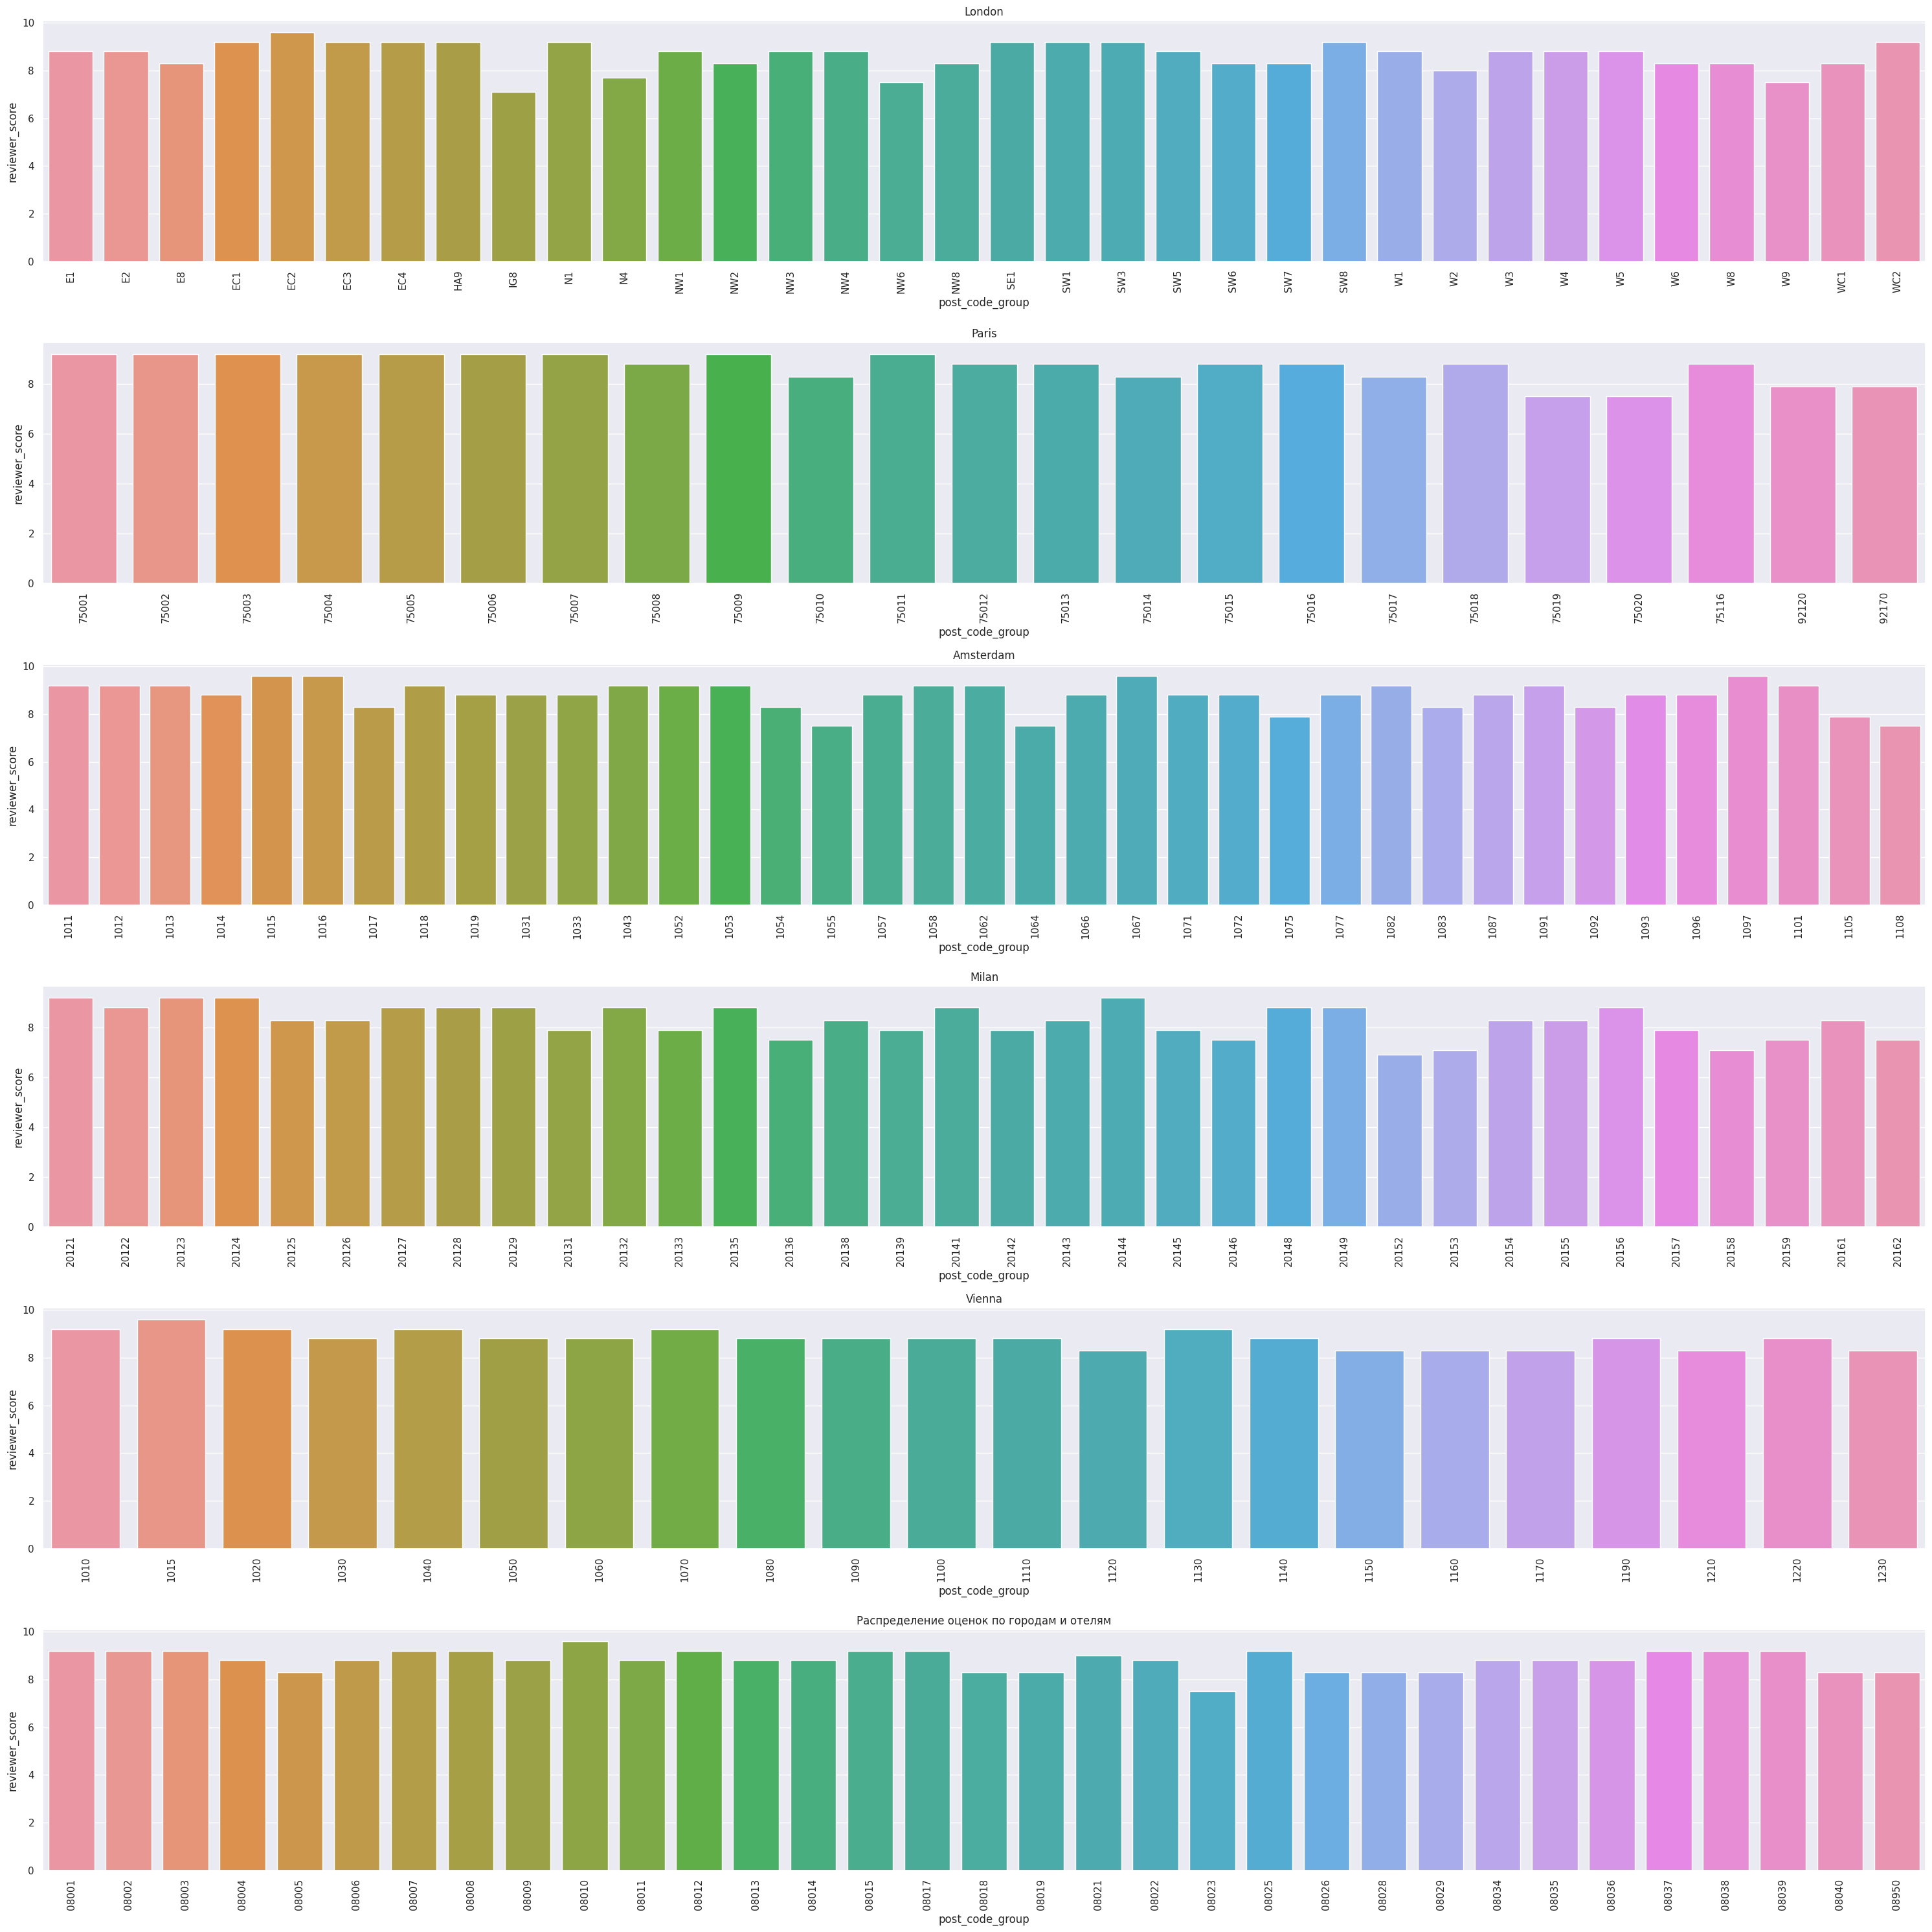

In [45]:
fig, ax = plt.subplots(6, 1, figsize=(30,30))
for i, city in enumerate(data.hotel_city.unique()):
    c = data[(data['sample'] == 1) & (data['hotel_city'] == city)].groupby('post_code_group')['reviewer_score'].median().reset_index()
    sns.barplot(x=c.post_code_group, y=c.reviewer_score, ax=ax[i])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
    ax[i].set_title(city)
plt.title('Распределение оценок по городам и отелям')
plt.tight_layout();

По графикам видно, что оценки сильно разнятся в разных районах города. 
Но важно учитывать то, что при появление в данных новых городов, необходимбужемт вручную изучить индексы и их специфику, чтобы понять как обработать адреса.

Считаю такой признак важным для дальнейшего прогнозирования оценки, поэтому на его основе создадим несколько новых:

**1. Ранг для каждого почтового индекса в рамках каждого города по уровню медианных оценок.**

In [46]:
# Группируем данные по названию города и подготовленному индексы и считаем медианную оценку
rank_post_code_score = data[data['sample'] == 1].groupby(['hotel_city', 'post_code_group'])['reviewer_score'].median().reset_index()

# На основание полученных средних оценок, формируем новый признак - ранг отеля для каждого города и потчового индекса по уровню средних оценок.
rank_post_code_score['rank_score_by_post_code_for_each_city'] = rank_post_code_score.groupby('hotel_city')['reviewer_score'].rank(method='dense', ascending=False)


# Объединяем новый признак с исходным датафреймом
data = data.merge(rank_post_code_score[
    ['hotel_city', 'post_code_group', 'rank_score_by_post_code_for_each_city']
    ] , on=['hotel_city', 'post_code_group'], how='left')

data.head(1)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,month_review,year_review,week_number,q_number,hotel_city,hotel_country,post_code,is_good_location,post_code_group,rank_score_by_post_code_for_each_city
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,leaving,1,1994,staff were amazing,...,2,2016,7,1,London,United Kingdom,W1J 8LT,0,W1,3.0


**1. Ранг для каждого почтового индекса в рамках каждого города по уровню количества низках оценок.**

In [48]:
# Группируем данные по названию города и подготовленному индексы и считаем медианную оценку
rank_post_code_lower_score = data[(data['sample'] == 1) & (data['reviewer_score'] <= 6)].groupby(['hotel_city', 'year_review', 'post_code_group'])['reviewer_score'].count().reset_index()

# На основание полученных средних оценок, формируем новый признак - ранг отеля для каждого города и потчового индекса по уровню средних оценок.
rank_post_code_lower_score['rank_cnt_lower_review_by_post_code'] = rank_post_code_lower_score.groupby(['hotel_city', 'year_review'])['reviewer_score'].rank(method='dense')


# Объединяем новый признак с исходным датафреймом
data = data.merge(rank_post_code_lower_score[
    ['hotel_city', 'year_review', 'post_code_group', 'rank_cnt_lower_review_by_post_code']
    ] , on=['hotel_city','year_review', 'post_code_group'], how='left')

data.head(1)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,year_review,week_number,q_number,hotel_city,hotel_country,post_code,is_good_location,post_code_group,rank_score_by_post_code_for_each_city,rank_cnt_lower_review_by_post_code
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,leaving,1,1994,staff were amazing,...,2016,7,1,London,United Kingdom,W1J 8LT,0,W1,3.0,30.0


Пропуски могут означать, что у отеля не было низких оценок, а значит его ранг должен быть - 1.

In [49]:
data['rank_cnt_lower_review_by_post_code'] = data['rank_cnt_lower_review_by_post_code'].fillna(1)

**3. Ранг для каждого почтового индекса в рамках каждого города по уровню количества высоких оценок.**

In [50]:
# Группируем данные по названию города и подготовленному индексы и считаем медианную оценку
rank_post_code_upper_score = data[(data['sample'] == 1) & (data['reviewer_score'] > 9)].groupby(['hotel_city', 'year_review', 'post_code_group'])['reviewer_score'].count().reset_index()

# На основание полученных средних оценок, формируем новый признак - ранг отеля для каждого города и потчового индекса по уровню средних оценок.
rank_post_code_upper_score['rank_cnt_upper_review_by_post_code'] = rank_post_code_upper_score.groupby(['hotel_city', 'year_review'])['reviewer_score'].rank(method='dense', ascending=False)


# Объединяем новый признак с исходным датафреймом
data = data.merge(rank_post_code_upper_score[
    ['hotel_city', 'year_review', 'post_code_group', 'rank_cnt_upper_review_by_post_code']
    ] , on=['hotel_city','year_review', 'post_code_group'], how='left')

data.head(1)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,week_number,q_number,hotel_city,hotel_country,post_code,is_good_location,post_code_group,rank_score_by_post_code_for_each_city,rank_cnt_lower_review_by_post_code,rank_cnt_upper_review_by_post_code
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,leaving,1,1994,staff were amazing,...,7,1,London,United Kingdom,W1J 8LT,0,W1,3.0,30.0,1.0


Пропуски в данных могут говорить о том, что у отеля не было таких высоких оценок и поэтому заполним пропуски максимальным рангом.

In [51]:
data.rank_cnt_upper_review_by_post_code = data.rank_cnt_upper_review_by_post_code.fillna(data.rank_cnt_upper_review_by_post_code.max())

**Посмотрим на корреляцию новых признаков и целевого признака**

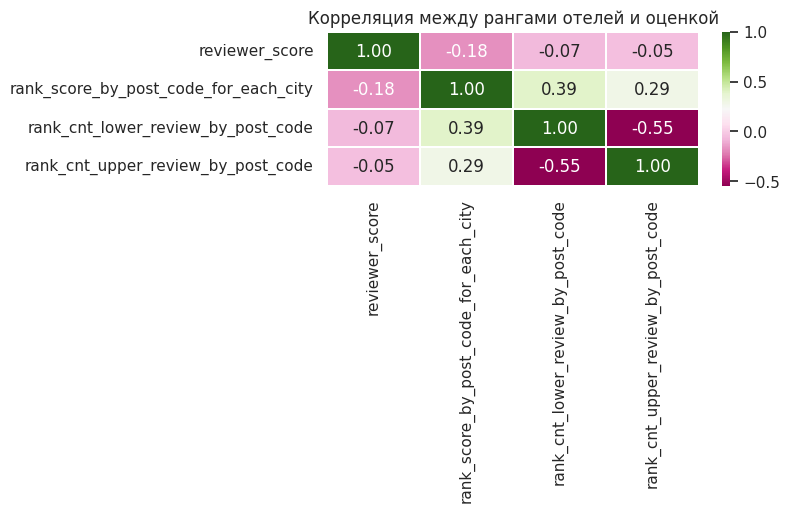

In [52]:
fig_, ax_ = plt.subplots(figsize=(6, 2))
corr = data[data['sample']==1][['reviewer_score', 'rank_score_by_post_code_for_each_city', 'rank_cnt_lower_review_by_post_code', 'rank_cnt_upper_review_by_post_code']].corr(method="spearman")
sns.heatmap(corr, 
            annot=True, 
            linewidths=0.1, 
            ax=ax_,  
            cmap='PiYG',
            fmt='.2f')
plt.title('Корреляция между рангами отелей и оценкой');

Больше всего влияние оказывает признак ранга отеля(по почтовому индексу) по его медианным оценкам за весь период в данных.
Но также есть влияние и 2х других признаков. Между ними есть отрицательная корреляция, но пока оставим оба их для обучения. Будем отбрасывать признаки со связью между собой более 0.7

In [53]:
num_col.extend(['rank_score_by_post_code_for_each_city', 'rank_cnt_lower_review_by_post_code', 'rank_cnt_upper_review_by_post_code'])

### **Поработаем с признаком total_number_of_reviews'.**
   * **Посмотрим на популярность отелей.**
   
   Создадим новый признак в котором посчитаем для каждого отеля, ранг его популярности по количеству отзывов о нем.

In [54]:
data['rank_popularity_hotel'] = data.groupby(['hotel_city', 'year_review'])['total_number_of_reviews'].rank(method='dense', ascending=False)
print(f"Получилось {data['rank_popularity_hotel'].nunique()} уникальных ранга")

Получилось 383 уникальных ранга


In [55]:
num_col.append('rank_popularity_hotel')

## Поработаем с признаками lat и lng.
Для начала получим центральные точки каждого города, чтобы в дальнейшем посчитать удаленность каждого отеля от центра города. Для этого соединим датафрейм city_centre (из csv файла с координатами центральных точек, который дополнительно был загружен в проект)

In [56]:
# Соединияем наш датафрейм с датафреймом центральных точек городов и добавим суффкс _city
data = data.merge(city_centre, left_on='hotel_city', right_on='city', how='left', suffixes=('', '_c'))

   * **Создадим признак 'distance_km', в котором расчитаем удаленность от центра города**

In [57]:
data['distance_km'] = data.apply(lambda x: great_circle((x.lat_c, x.lng_c), (x.lat, x.lng)).kilometers, axis=1)

In [58]:
data.distance_km = data.distance_km.round() / 2

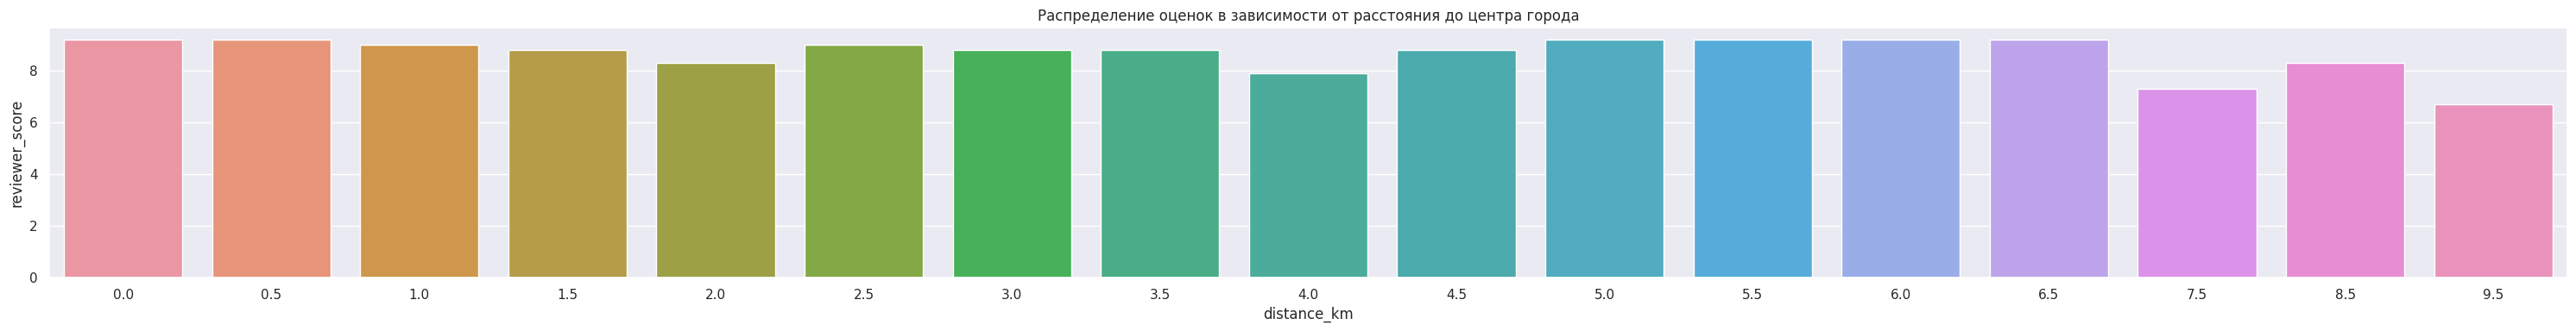

In [59]:
fig, ax = plt.subplots(figsize=(30,4))
c = data[data['sample'] == 1].groupby('distance_km')['reviewer_score'].median().reset_index()
sns.barplot(x=c.distance_km, y=c.reviewer_score)
plt.title('Распределение оценок в зависимости от расстояния до центра города')
plt.tight_layout();

Объединаяем рейтинг с ранее созданным признаком is_good_location. Для тех отелей, которые находятсян а расстоянии меньше 2 км от центра города проставим 1, что будет означать хорошую локацию отеля.

In [60]:
data['is_good_location'] = data.apply(lambda x: 1 if x.distance_km <= 0.5 else x.is_good_location, axis=1 )

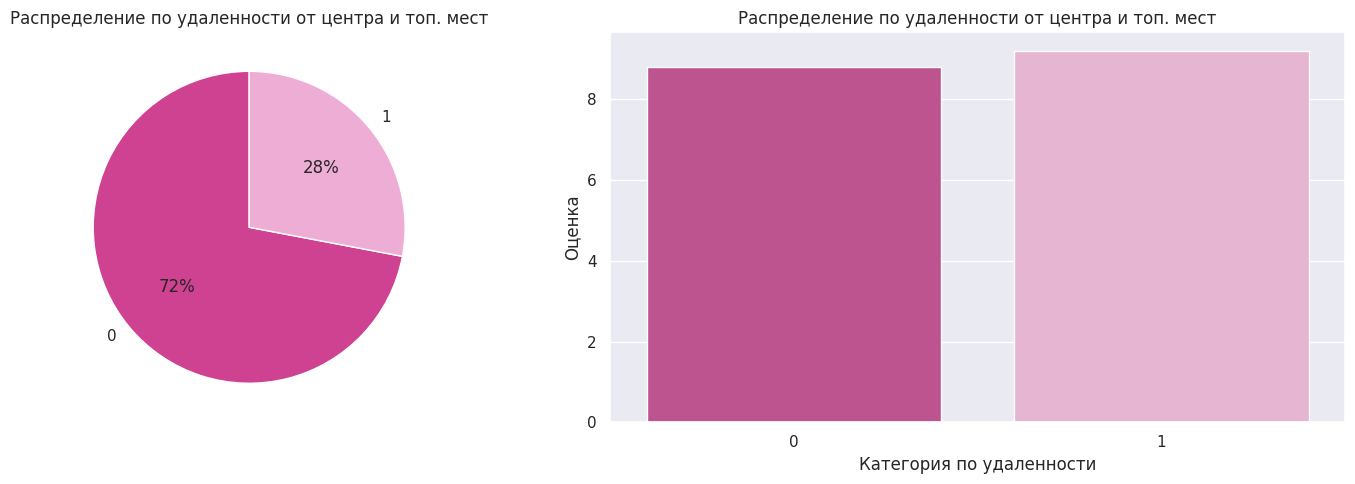

In [61]:
pie_bar('is_good_location', 'Распределение по удаленности от центра и топ. мест',  'Категория по удаленности')

Отели которые расположены ближе к центру города имеют более высокие оценки.
Проверим действительно ли это так.

Нулевая гипотеза: Отели, расположенные в центре имеют оценки равные или ниже оценок более удаленных отелей.

Альтернативная: Отели, расположенные в центре имеют оценки выше оценок более удаленных отелей.

In [62]:
# средние оценки по удаленности
dist_lower = data.loc[(data['sample'] == 1) & (data['is_good_location'] == 1), 'reviewer_score']
dist_upper = data.loc[(data['sample'] == 1) & (data['is_good_location'] != 1), 'reviewer_score']


# проводим тест Шапиро-Уилка
shapiro(dist_lower, 1)
shapiro(dist_upper, 2)

Группа 1: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 2: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 108242.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 278561.
  res = hypotest_fun_out(*samples, **kwds)


In [63]:
# проводим тест. У нас 2 независимых количественных группы, распределение отлично от нормального. Используем U Манна
stat_test('mannwhitneyu', [dist_lower, dist_upper], alt='greater')

# Считает коэффициент Крайна
cohens(dist_lower, dist_upper)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


"Cohen's d: 0.3, уровень эффекта: малый"

In [64]:
cat_col.append('is_good_location')

## **Извлечем полезную информацию из 'tags'** 

In [65]:
# Посмотрим что часто встречалось в признаке tags
unique_tags = []
data['tags'] = data['tags'].str.replace('[', '').str.replace(']', '').str.replace("' ", '').str.replace(" '", '').str.split(',')
for i in data.tags:
    for j in i:
        unique_tags.append(j.strip().lower())
unique_tags = pd.DataFrame(Counter(unique_tags).most_common())
unique_tags.columns = ['tag', 'count']
unique_tags[:15]

,tag,count
0,leisure trip,417778
1,submitted from a mobile device,307640
2,couple,252294
3,stayed 1 night,193645
4,stayed 2 nights,133937
5,solo traveler,108545
6,stayed 3 nights,95821
7,business trip,82939
8,group,65392
9,family with young children,61015


In [66]:
data.tags = data.tags.apply(lambda x: ','.join(x))

   * Извлечем из тегов типы комнат и посмотрим имеют ли они влияние на оценку отеля.

In [67]:
# Функция поиска типов комнат
def types_room(tags):
    type_of_rooms = [
        'studio', 'single', 'two bedroom apartment',
        'twin', 'triple', 'standard', 'duplex', 'executive room',
        'superior', 'family room', 'queen', 'sextuple room',
        'king', 'deluxe', 'classic', '2 rooms', '4 rooms', '3 rooms', 'suit',
        'luxury room', 'apartment', 'quadruple room', 'one bedroom apartment',
        'room selected at check in', 'comfort', 'large room', 'connecting rooms',
        'camper room', 'club room', 'city room', 'wonderful room', 'ordinary room',
        'panoramic room', 'premium room', 'business class room', 'art room', 'loft',
        'townhouse club', 'mega room', 'adjacent rooms', 'premier room', 'garden room',
        'romantic special offer', 'maisonette', 'privilege room', 'double room', 'room with dock view',
        'room with ramblas view', 'luxury four poster', 'penthouse', 'intuition room', 'special room',
        'royal room', 'mini room', 'communicating room', 'room with park view', 'sky room', 'quintuple room',
        'garden cottage', 'cozy room', 'emotion room', 'room with river view', 'censation room', 'cosy room',
        'classique square', 'poster room', 'feature room', 'room assigned at check in', 'business room', 'corner room',
        'prestige room', 'level room', 'sensation room', 'special offer', 'spectacular room', 'mandarin room',
        'ambassadors room', 'fabulous room', 'secret room', 'room with view', 'halkin room', 'plus room', 'atrium',
        'mezzanine room', 'penta room'
    ]
    
    for type in type_of_rooms:
        if type in tags.lower():
            return type
    return 'other'

# Создаем признак, в котором укажем тип комнаты
data['category_of_room'] = data.tags.apply(types_room)

In [68]:
# Посмотрим на средние оценки по типам комнат
display(data[data['sample'] == 1].groupby('category_of_room')['reviewer_score'].median().round(2).reset_index().sort_values(by='reviewer_score')[:20])

,category_of_room,reviewer_score
9,business room,7.50
41,mega room,7.90
3,adjacent rooms,7.90
8,business class room,7.90
26,fabulous room,7.90
2,4 rooms,7.95
37,luxury four poster,8.30
43,mini room,8.30
45,other,8.30
46,panoramic room,8.30


   * **Если путешествовали группой поставим 1**

In [69]:
data['is_group_trip'] = data['tags'].apply(lambda x: 1 if 'group' in x.lower() or 'friend' in x.lower() else 0)

   * **Если путешествовали парой (молодожены, супруги)**

In [70]:
data['is_couple_trip'] = data['tags'].apply(lambda x: 1 if 'couple' in x.lower() else 0)

   * **Если рецензент отправился один в путешествие, то ставим 1.**

In [71]:
data['is_solo_trip'] = data['tags'].apply(lambda x: 1 if "solo" in x.lower() else 0)

   * **Путешествовали ли с детьми**

In [72]:
data['is_family_trip'] = data.tags.apply(lambda x: 1 if 'child' in x.lower() else 0)

   * Теперь мы можем выделить несколько категорий по количеству людей в путешествии:
   1. Если путешествует один - 1 категория
   2. Если путешествует пара - 2 категория
   3. Если путешествуют с детьми или с друзьями/ группой - 3 категория

In [73]:
# Ставим категорию в зависимости от количества людей
def category_of_cnt_people(solo, group, couple, family):
    """Определяем категорию отеля по количеству людей в поездках
    
    Параметры:
    solo, group, couple, family (int): Отражает встречался ли этот признак в отзыве
    
    Возвращает:
    int : Номер категории
    """
    
    if solo == 1:
        return 1
    
    elif couple == 1:
        return 2
    
    elif family == 1: 
        return 3
    
    elif group == 1:
        return 4

# Создаем новый признак, категория по количеству людей
data['cat_by_cnt_people'] = data.apply(lambda x: category_of_cnt_people(x.is_solo_trip, x.is_group_trip, x.is_couple_trip, x.is_family_trip), axis=1)

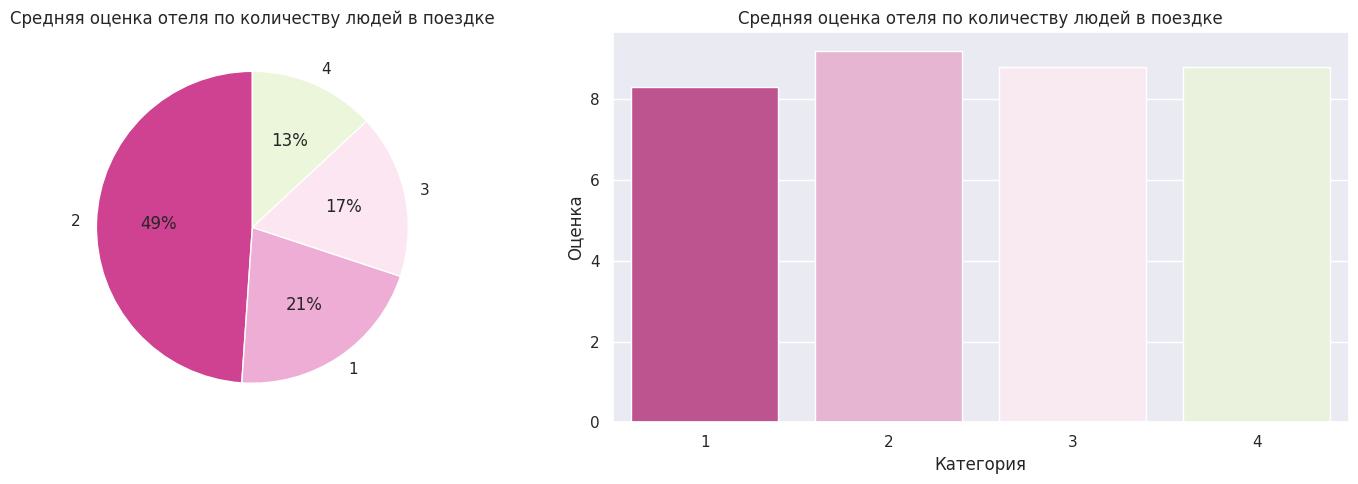

In [74]:
pie_bar('cat_by_cnt_people', 'Средняя оценка отеля по количеству людей в поездке', 'Категория')

Рецензенты, которые путешествовали одни ставили более низкие оценки.

Снова формулируем гипотезы и выясняем статистически значимо предположение или нет.

**Нулевая гипотеза:**
Различий в оценках между рецензентами из разных групп(по количеству человек в поездке) нету.

**Альтернативная гипотеза:**
Оценки в разных группах рецензентов по количеству человек в плездке не равны.

In [75]:
# средние оценки по количеству людей
solo = data.loc[(data['sample'] == 1) & (data['cat_by_cnt_people'] == 1), 'reviewer_score']
couple =  data.loc[(data['sample'] == 1) & (data['cat_by_cnt_people'] == 2), 'reviewer_score']
fam = data.loc[(data['sample'] == 1) & (data['cat_by_cnt_people'] == 3), 'reviewer_score']
gr_fr = data.loc[(data['sample'] == 1) & (data['cat_by_cnt_people'] == 4), 'reviewer_score']

# проводим тест Шапиро-Уилка
shapiro(solo, 1)
shapiro(couple, 2)
shapiro(fam, 3)
shapiro(gr_fr, 4)

Группа 1: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 2: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 3: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 4: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 81235.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 189212.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 65785.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 50571.
  res = hypotest_fun_out(*samples, **kwds)


In [76]:
# проводим тест. У нас 3 независимых количественных группы, распределение отлично от нормального.
stat_test('kruskal', [solo, couple, fam, gr_fr])

print(cohens(solo, couple))
print(cohens(couple, fam))
print(cohens(solo, gr_fr))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
Cohen's d: 0.5, уровень эффекта: средний
Cohen's d: 0.2, уровень эффекта: малый
Cohen's d: 0.3, уровень эффекта: малый


Посмотрим на различия в оценках для разного количества людей и размеров комнат.
Сначала отнесем к other те типы комнат, которых в данных менее 500, чтобы уменьшить размерность этого признака.

In [77]:
cat_r = data.category_of_room.value_counts().reset_index()
cat_r = list(cat_r[cat_r['count'] <= 500]['category_of_room'])
data['category_of_room'] = data.category_of_room.apply(lambda x: 'other' if x in cat_r else x)
data.category_of_room.nunique()

20

In [78]:
# Посмотрим на средние оценки по типам комнат
median_score_by = data[data['sample'] == 1].groupby(['hotel_city','cat_by_cnt_people','category_of_room']).agg(median_score_by_pcode_people_room=('reviewer_score','median')).round(1).reset_index()
median_score_by


,hotel_city,cat_by_cnt_people,category_of_room,median_score_by_pcode_people_room
0,Amsterdam,1,2 rooms,8.8
1,Amsterdam,1,apartment,6.9
2,Amsterdam,1,classic,8.8
3,Amsterdam,1,comfort,8.8
4,Amsterdam,1,deluxe,8.8
...,...,...,...,...
462,Vienna,4,studio,8.8
463,Vienna,4,suit,9.2
464,Vienna,4,superior,9.2
465,Vienna,4,triple,8.8


Как видно из таблицы во всех городах разные категории людей(по количеству человек в поездке) низко оценивали 4 rooms номера, особенно в Вене.

In [79]:
# Посмотрим на средние оценки по типам комнат
median_score_by_three_category = data[data['sample'] == 1].groupby(['post_code_group','cat_by_cnt_people','category_of_room']).agg(median_score_by_pcode_people_room=('reviewer_score','median')).round(1).reset_index()
median_score_by_three_category


data = data.merge(median_score_by_three_category, on=['post_code_group', 'cat_by_cnt_people', 'category_of_room'], how='left')

Образовалось около 300 пропусков в новом признаке, заполним его из признака average_score

In [80]:
data.median_score_by_pcode_people_room = data.median_score_by_pcode_people_room.fillna(data.average_score)

In [81]:
data = pd.get_dummies(data, columns=['category_of_room'], prefix='room')
data = pd.get_dummies(data, columns=['cat_by_cnt_people'], prefix='category_cnt_people')

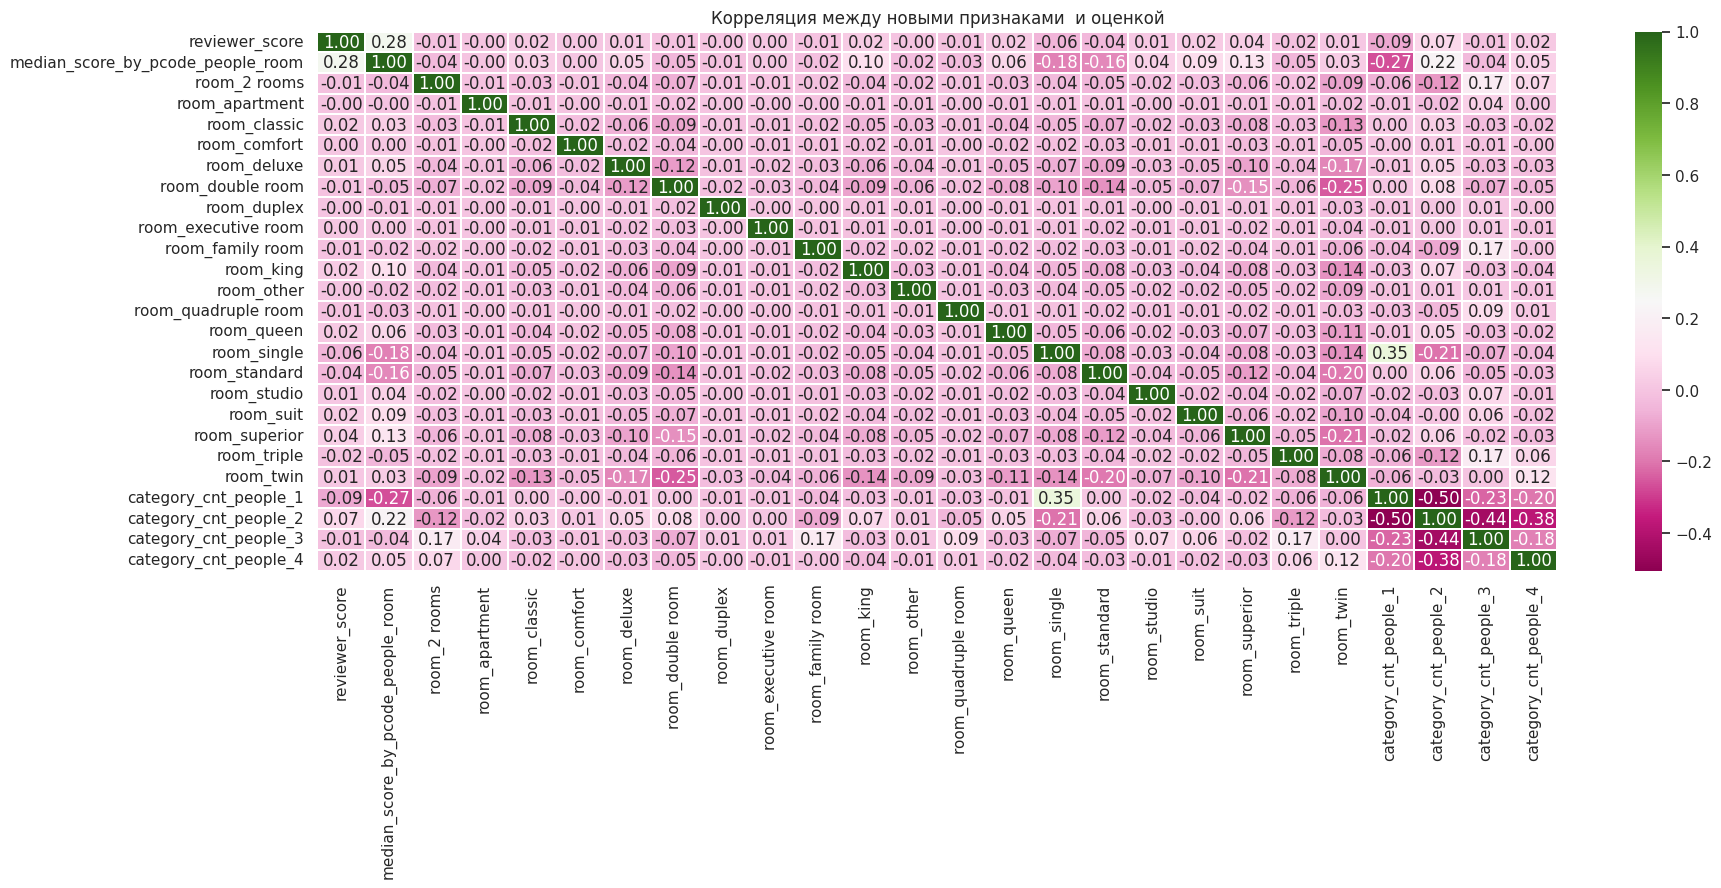

In [82]:
fig_, ax_ = plt.subplots(figsize=(20, 7))
corr = data[data['sample']==1][
                                ['reviewer_score', 'median_score_by_pcode_people_room', 'room_2 rooms', 'room_apartment', 'room_classic', 'room_comfort',
                                'room_deluxe', 'room_double room', 'room_duplex', 'room_executive room',
                                'room_family room', 'room_king', 'room_other', 'room_quadruple room',
                                'room_queen', 'room_single', 'room_standard', 'room_studio',
                                'room_suit', 'room_superior', 'room_triple', 'room_twin',
                                'category_cnt_people_1', 'category_cnt_people_2',
                                'category_cnt_people_3', 'category_cnt_people_4']
                                ].corr(method="spearman")
sns.heatmap(corr, 
            annot=True, 
            linewidths=0.1, 
            ax=ax_,  
            cmap='PiYG',
            fmt='.2f')
plt.title('Корреляция между новыми признаками  и оценкой');

У признака 'median_score_by_pcode_people_room' корреляция с целевым признаком практически 0.3, зависимость между ними прослеживается. Для закодированных типов комнат и категорий групп людей корреляция практически отстутсвует. Но на данном этапе оставим все признаки. В дальнейшем надо будет сравнить их вклад и результат обучения с ними и без них.

In [83]:
num_col.append('median_score_by_pcode_people_room')

In [84]:
cat_col.extend(['room_2 rooms', 'room_apartment', 'room_classic', 'room_comfort',
       'room_deluxe', 'room_double room', 'room_duplex', 'room_executive room',
       'room_family room', 'room_king', 'room_other', 'room_quadruple room',
       'room_queen', 'room_single', 'room_standard', 'room_studio',
       'room_suit', 'room_superior', 'room_triple', 'room_twin',
       'category_cnt_people_1', 'category_cnt_people_2',
       'category_cnt_people_3', 'category_cnt_people_4'])

   * **Если это туристическая поездка, поставим 1**

In [85]:
data['is_leisure_trip'] = data['tags'].apply(lambda x: 1 if 'leisure trip' in x.lower() else 0)

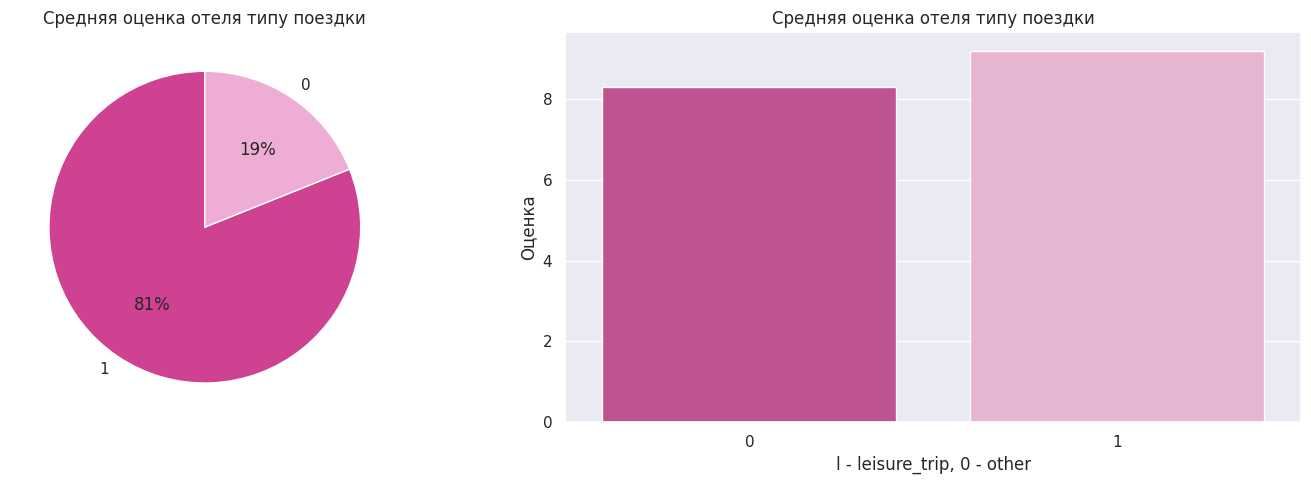

In [86]:
pie_bar('is_leisure_trip','Средняя оценка отеля типу поездки', 'l - leisure_trip, 0 - other') 

Предполагаем:
Оценка отлей с типом поездки - leisure выше, чем у других типов.

**Нулевая гипотеза:** Оценка отелей с типом поездки leisure равна или ниже оценки других отелей.

**Альтернативная:** Оценка отелей с типом поездки leisure выше оценки других отелей.

Проверяем:

In [87]:
is_leis = data.loc[(data['sample'] == 1) & (data['is_leisure_trip'] == 1), 'reviewer_score']
other_t = data.loc[(data['sample'] == 1) & (data['is_leisure_trip'] != 1), 'reviewer_score']

shapiro(is_leis, 1)
shapiro(other_t, 2)

Группа 1: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 2: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 313593.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 73210.
  res = hypotest_fun_out(*samples, **kwds)


In [88]:
# Проводим статистические тесты Мана-Уитни и Крайна
stat_test('mannwhitneyu', [is_leis, other_t], alt='greater')

cohens(is_leis, other_t)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


"Cohen's d: 0.5, уровень эффекта: средний"

Действительно у отелей, рецензенты которых путешествовали просто для отдыха, оценки выше.

In [89]:
cat_col.extend(['is_leisure_trip'])

   * Посчитаем на сколько дней останаливались путешественники. Если значение пропущено, поставим 1 ночь, так как рецензенты точно должны были остаться хотя бы на одну ночь.

In [90]:
data['nights'] = data['tags'].apply(lambda x: re.findall(r'[0-9]{1,3} night.{0,}', x) if 'night' in x.lower() else [])
data.nights = data.nights.apply(lambda x: int(x[0].split()[0]) if len(x) != 0 else np.nan)
data.nights = data.nights.fillna(data.nights.mode())

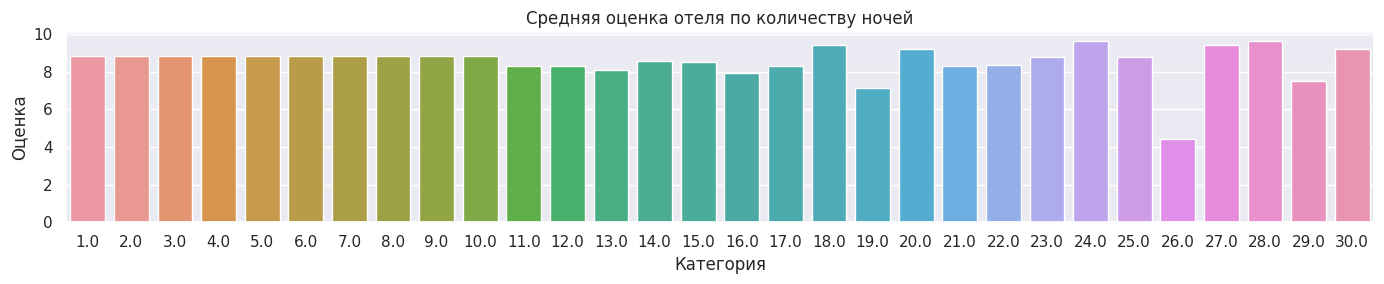

In [91]:
# Создаем фигуру и ось с заданными размерами
fig1, ax1 = plt.subplots(figsize=(14, 3))

# Группируем по количеству ночей и считаем медианную оценку
nights = data[data['sample'] == 1].groupby(['nights'])['reviewer_score'].median().reset_index()

# Создаем столбчатую диаграмму
sns.barplot(
    x=nights['nights'],           # Количество ночей
    y=nights['reviewer_score']    # Медианная оценка рецензентов
)

# Заголовок и метки осей
plt.title('Средняя оценка отеля по количеству ночей')
plt.xlabel('Категория')
plt.ylabel('Оценка')

# Автоматическая настройка компоновки графика
plt.tight_layout()

# Отображаем график
plt.show()

In [92]:
data[data.nights <= 10]['reviewer_score'].mean() > data[data.nights > 10]['reviewer_score'].mean()

True

Рецензенты, которые провели в отеле до 10 дней ставили в среднем оценки выше, чем те, кто отдыхал дольше.

Нулевая гипотеза:
Рецензенты, останавливающиеся в отеле до 10 дней ставят оценки равные или ниже остальных рецензентов.
Альтернативная гипотеза:
Рецензенты, останавливающиеся в отеле до 10 дней ставят оценки выше остальных рецензентов.

In [93]:
# средние оценки по типу комнат
lower_10 = data.loc[(data['sample'] == 1) & (data['nights'] <=  10), 'reviewer_score']
upper_10 = data.loc[(data['sample'] == 1) & (data['nights'] >  10), 'reviewer_score']


# проводим тест Шапиро-Уилка
shapiro(lower_10, 1)
shapiro(upper_10, 2)

Группа 1: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 2: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 385482.
  res = hypotest_fun_out(*samples, **kwds)


In [94]:
# проводим тест. У нас 2 независимых количественных группы, распределение отлично от нормального. Используем U Манна
stat_test('mannwhitneyu', [lower_10, upper_10], alt='greater')

cohens(lower_10, upper_10)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


"Cohen's d: 0.3, уровень эффекта: малый"

В целом до 10 ночей у нас идет стабильный уровень оценок, а дальше начинаются очень нестабильные скачки. Кому то понравилось долгое пребывание в отеле, а кто то был крайне разочарован. Оставим в признаке только маячок о том, что поездка составляла до 10 дней.

In [95]:
# Изменим признак nights. ВЫделим 2 категории: 1 - останавливались до 10 дней, 0 - больше 10 дней.
data.nights = data.nights.apply(lambda x: 1 if x <= 10 else 0)

#Добалвляем признак в список для обучения
cat_col.append('nights')

   * **Укажем какие рецензенты бронировали через мобильное приложение**

In [96]:
data['submitted_from_mobile_device'] = data['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)

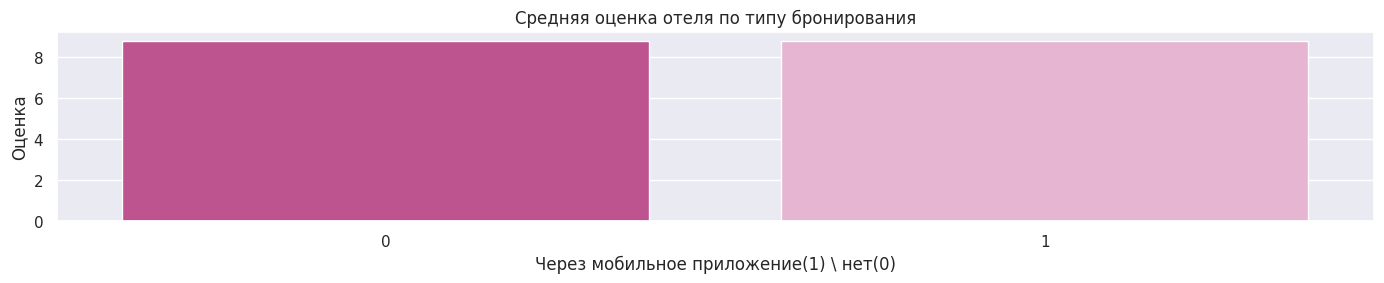

In [97]:
fig1, ax1 = plt.subplots(figsize=(14, 3))

# Группируем по типу бронирования
mob = data[data['sample']==1].groupby('submitted_from_mobile_device')['reviewer_score'].median().reset_index()

sns.barplot(
    x=mob.submitted_from_mobile_device, 
    y=mob.reviewer_score
)
plt.title('Средняя оценка отеля по типу бронирования')
plt.xlabel('Через мобильное приложение(1) \ нет(0)')
plt.ylabel('Оценка')
plt.tight_layout();

То, что что рецензенты бронировали отель через мобильное приложение, не повлияло на оценку отеля.

**Посчитаем количество уникальных тегов каждого отеля**

In [98]:
# Функция для подсчета уникальных тегов
def unique_tags(tags):
    # Объединяем теги, удаляем пробелы и приводим к нижнему регистру
    all_tags = [tag.strip().lower() for tag in ','.join(tags).split(',')]
    # Возвращаем количество уникальных тегов
    return len(set(all_tags))

# Используем метод groupby для агрегации данных
df1 = data.groupby('hotel_name')['tags'].agg(unique_tags).reset_index()

# Переименовываем столбцы для ясности
df1.columns = ['hotel_name', 'cnt_unique_tags']


In [99]:
# Соединяем с исходными данными
data = data.merge(df1, on='hotel_name', how='left')

In [100]:
data['rank_cnt_tags']  = data['cnt_unique_tags'].rank(method='dense', ascending=True)
data[data['sample'] == 1][['reviewer_score', 'rank_cnt_tags']].corr(method='spearman').round(2)

,reviewer_score,rank_cnt_tags
reviewer_score,1.00,-0.08
rank_cnt_tags,-0.08,1.00


In [101]:
num_col.append('rank_cnt_tags')

### **5. Поработаем с признаками hotel_country и reviewer_nationality'.**

Создадим признак 'reviewer_from_same_country', где поставим True. если рецензент, продивает в той же стране, где находится отель

   * Является ли рецензент жителем города, где расположен отель

In [102]:
# Создание нового столбца, который указывает, является ли рецензент местным
data['reviewer_from_same_country'] = data.apply(lambda x: 1 if x['reviewer_nationality']  == x['hotel_country'] else 0, axis=1)

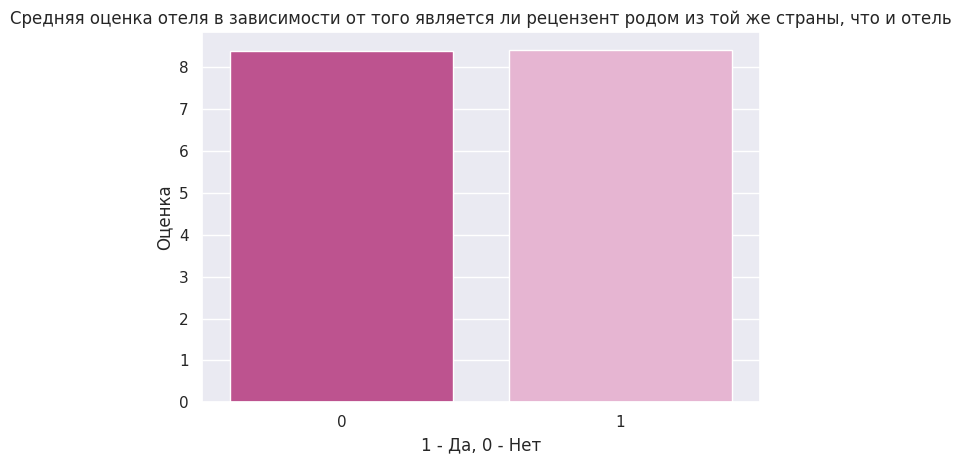

In [103]:
same_country_score = data[data['sample'] == 1].groupby('reviewer_from_same_country')['reviewer_score'].mean().reset_index()

sns.barplot(
    x=same_country_score.reviewer_from_same_country, 
    y=same_country_score.reviewer_score
)
plt.title('Средняя оценка отеля в зависимости от того является ли рецензент родом из той же страны, что и отель')
plt.xlabel('1 - Да, 0 - Нет')
plt.ylabel('Оценка')
plt.tight_layout();

Разница в уровне оценок практически отсутсвует, не будем использовать этот признак

Переходим к признаку reviewer_nationality

У нас достаточно много уникальных значений в признаке национальности рецензента. Попробуем преобразовать этот признак. Создадим новый признак, в котором укажем из какой части света рецензент. Для этого:

1. Подгрузим данные о названиях стран и их локацией(в какой части света расположены)
2. Создадим новый признак reviewer_location в котором будут указаны части света каждого рецензента.
3. Если есть пропуски, заменим их на Unknown
4. Посмотрим на распределение и проверим значимость наших предположений.

In [104]:
print(f'В признаке reviewer_nationality - {data.reviewer_nationality.nunique()} уникальных значений')

name_of_countries = pd.read_csv('/kaggle/input/name-of-countries/name_of_countries.csv')
name_of_countries.drop(0, axis=0, inplace=True)
name_of_countries = name_of_countries[['english', 'location']]

data = data.merge(name_of_countries, left_on='reviewer_nationality', right_on='english', how='left')
data = data.rename(columns={"location": "reviewer_location"})
data.fillna({'reviewer_location': 'Unknown'}, inplace=True)

print(f'После создания нового признака с опрпделнием из какой части света рецензент, уникальных значений стало - {data.reviewer_location.nunique()}')

В признаке reviewer_nationality - 227 уникальных значений
После создания нового признака с опрпделнием из какой части света рецензент, уникальных значений стало - 7


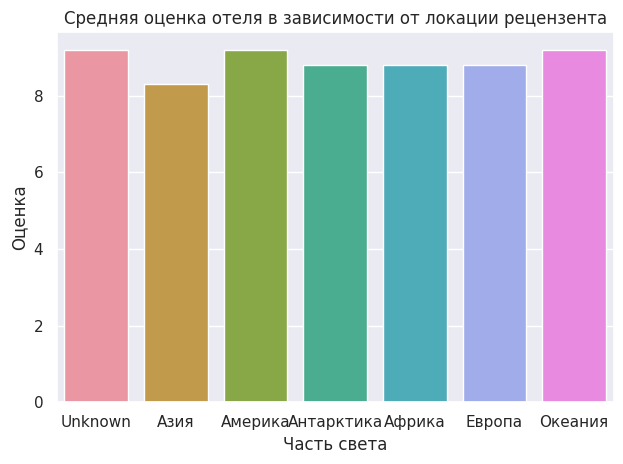

In [105]:
location_score = data[data['sample'] == 1].groupby('reviewer_location')['reviewer_score'].median().reset_index()

sns.barplot(
    x=location_score.reviewer_location, 
    y=location_score.reviewer_score)
plt.title('Средняя оценка отеля в зависимости от локации рецензента')
plt.xlabel('Часть света')
plt.ylabel('Оценка')
plt.tight_layout();

Напрашиваются 3 группы:

* рецензенты из Азии
* рецензенты из Антарктики, Африки и Европы
* остальные рецензенты

In [106]:
def cat_loc(location):
    '''
    Определяет категорию по локации рецензента(часть света)
    
    Параметры:
    location (str): Часть света, в которой находится рецензент 
    
    Возвращает:
    int: Категорию 0,1,2
    '''
    if location == 'Азия':
        return 1
    elif location in ['Антарктика', 'Африка', 'Европа']:
        return 2
    else:
        return 3
    
data['reviewer_location'] = data.reviewer_location.apply(cat_loc)

Есть различия в оценках отелей в зависимости от локации рецензента. Проверим есть ли статистическая значимость в этом.

Для этого сформулирем нулевую и альтернативную гипотезу:

**Нулевая:** Средние оценки у рецензентов из разных частей света равны.

**Альтернативная:** Средние оценки рецензентов из разных частей света не равны.

Проведем статистический тест.

In [107]:
# значения оценок отелей
azia = data.loc[(data['sample'] == 1) & (data['reviewer_location'] == 1), 'reviewer_score']
evr_an_afr = data.loc[(data['sample'] == 1) & (data['reviewer_location'] == 2), 'reviewer_score']
oth = data.loc[(data['sample'] == 1) & (data['reviewer_location'] == 3), 'reviewer_score']

# проводим тест Шапиро-Уилка
shapiro(azia, 1)
shapiro(evr_an_afr, 2)
shapiro(oth, 2)

Группа 1: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 2: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 2: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 52313.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 272894.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 61596.
  res = hypotest_fun_out(*samples, **kwds)


In [108]:
stat_test('kruskal', [azia, evr_an_afr, oth])

print(cohens(azia, evr_an_afr))
print(cohens(evr_an_afr, oth))
print(cohens(oth, azia))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
Cohen's d: 0.3, уровень эффекта: малый
Cohen's d: 0.3, уровень эффекта: малый
Cohen's d: 0.5, уровень эффекта: средний


Выявили статистически значимую разницу между оценками рецензентов из разных частей света Создалим для каждой локации свой признак и запишем их в список для обучения.

In [109]:
cat_col.extend(['reviewer_location'])

## Поработаем с позитивными и негативными отзывами

**Далее начнем работу именно с отзывами, ведь это основной фактор по которому можно оценить насколько рецензент остался доволен пребыванием в отеле.**


1. Какие отзывы чаще всего встречались в негативных и положительных отзывах.

In [110]:
# Посмотрим, что чаще всего встречалось среди негтивных отзывов
most_common_neg = data.negative_review.value_counts().reset_index()
most_common_neg[most_common_neg['count'] > 25][90:120]

,negative_review,count
90,room a bit small,72
91,rooms are very small,70
92,no bar,69
93,nothing i can think of,69
94,room was a bit small,69
95,no dislikes,68
96,nothing to say,68
97,room,67
98,rooms are small,67
99,no pool,66


Создадим признак маячок, который покажет, что в негативном отзыве не было негатива.

In [111]:
def not_negative(review):
    positive = ['no negative', 'nothing', 'nothing to dislike', 'absolutely nothing', 'no complaints', 'none', 'nothing really', 'all good', 'everything was great', 'nothing to complain about',
             'i liked everything', 'nothing all good', 'everything was good', 'liked everything', 'nothing it was perfect', 'nothing everything was great', 'all was good', 'we liked everything',
             'nothing i didn t like', 'no negatives', 'it was all good', 'loved everything', 'there was nothing to dislike', 'all ok', 'no dislikes', 'everything was excellent', 'no problems',
             'everything was ok']
    for word in positive:
        if review == word:
            return 1
    else:
        return 0
    
data['all_was_good'] = data.negative_review.apply(not_negative)

In [112]:
# Посмотрим, что чаще всего встречалось среди позитивных
most_common_pos = data.positive_review.value_counts().reset_index()
most_common_pos[most_common_pos['count'] > 100][:25]

,positive_review,count
0,no positive,35946
1,location,11945
2,everything,3314
3,nothing,1731
4,great location,1687
5,the location,1606
6,good location,1496
7,breakfast,795
8,friendly staff,733
9,excellent location,639


Отметим точно не позитивные отзывы маячком.

In [113]:
def not_positive(review):
    negative = ['no positive', 'nothing', 'none', 'all was bad']
    for word in negative:
        if review == word:
            return 1
    else:
        return 0
    
data['all_was_bad'] = data.positive_review.apply(not_positive)

## Работаем с негативными отзывами. Смотрим какие фразы встречались чаще и считаем количество негативных слов в отзывах.

In [114]:
# Попробуем посмотреть какие фразы встречались в негативных отзывах часто
negative = []
words_for_find = ['breakfast', 'clean', 'hotel', 'room', 'bad', 'terrible',
                 'expensive', 'location', 'shower', 'service',
                 'experience', 'staff', 'personal', 'worst',
                  'price', 'wifi', 'parking', 'liked', 'loved',
                  'bathroom', 'kitchen', 'restaurant', 'reception',
                  'floor', 'lift', 'area', 'pillow', 'condition',
                  'single', 'water', 'noisy', 'air', 'nothing', 'was',
                  'noise', 'worse', 'clean', 'rude', 'poor', 'uncomfortable',
                  'unfriendly', 'unhelpful', 'disappointing', 'badly', 'problem',
                  'amazing', 'good', 'help', 'cold', 'price', 'awful', 'perfect',
                  'all', 'probably', 'window', 'hotel', 'staff', 'bed'
                 ]
# Очищаем от знаков негативные отзывы.
neg_r = data.negative_review.str.replace(',','').str.replace('.', '').str.replace('!','').str.split()

# Функция для извлечения фраз с ключевыми словами
def find_phrase(review, window_size=4):
    result = []
    for i, word in enumerate(review):
        if any(w in word for w in words_for_find):
            start = max(i - window_size, 0)
            end = min(i + window_size + 1, len(review))
            result.append(' '.join(review[start:end]))
    return result

# Список для будущих фраз с ключевыми словами
all_phrase_neg = []

# Из каждого негативного отзыва извлекаем фразы разной длины
for review in neg_r:
    all_phrase_neg.extend(find_phrase(review))

# Считаем частоту появления этих фраз
most_common_phrase_neg = pd.DataFrame(Counter(all_phrase_neg).most_common(5000))

In [115]:
most_common_phrase_neg[60:90]

,0,1
60,no bad experience,130
61,room was quite small,129
62,breakfast could have been better,125
63,room was very small and,123
64,there was nothing we didn t,121
65,nothing in particular,121
66,everything was fine,120
67,there was nothing we didn t like,117
68,rooms are a bit small,115
69,wifi,112


Внимательно все изучив могу сдлеать следущий вывод:
1. Рецензенты часто жаловались на размер и чистоту комнаты
2. Жаловались на завтрак
3. Жаловались на персонал
4. Оставались недовольны ценой
5. Большое количество тех, кто высказался, что нет негатива или наоборот сказал, что все хорошо.

Для начала создадим признак где посчитаем сколько в каждом негативном отзыве встретилось действительно негативных слов. А потом для каждого "недовольства" рецензента создадим свой признак.

In [116]:
# Склеим оба отзыва в один
data['full_review'] = (data.positive_review + data.negative_review).str.replace(r'[^\w\s]', '', regex=True).str.split()

def count_negative_words(review_n): 
        
    negative_words_for_negative_review = [
     'aggravated','annoyed','awful',
     'bad','bad experience','badly',
     'bitter','blemished','bothered',
     'broken','careless', 'chaotic',
     'not clean', 'cluttered','cold',
     'cramped','dangerous', 'dark',
     'deficient','depressing','didn t liked',
     'didn t loved','dilapidated','dingy',
     'dirty', 'disappointing','disappointment',
     'disconcerting','discontented', 'disgruntled',
     'disgusting', 'disheartening','disorderly',
     'disorganized','dissatisfied', 'disturbing',
     'dusty','exasperated','exhausting','expensive',
     'fault','faulty','filthy','flawed','foul odor',
     'furious', 'gloomy', 'grimy','imperfect',
     'inadequate','inauspicious','incensed',
     'incompetent', 'inconsiderate','indifferent',
     'inflexible','insufficient', 'irked',
     'irresponsible','lackluster', 'low-quality',
     'makeshift', 'malodorous', 'marred', 'mediocre',
     'mildewed','minor','musty','nasty','neglect',
     'noisy','not comfortable','not cozy',
     'nothing good', 'not good', 'not friendly',
     'obsolete','outdated','overcrowded','perturbed',
     'poor', 'poorly','probably','problem', 'problems',
     'properly','ramshackle', 'resentful', 'restless',
     'rickety', 'risky', 'rude','ruined', 'sad',
     'scary', 'shabby','shoddy','sick','slow','smell',
     'spoiled','stained','subpar','tainted','tasteless',
     'n t good', 'n t clean', 'n t comfortable',
     'terrible','thoughtless','tight','tiny','troubled',
     'uncomfortable','understaffed','uneasy','unfriendly',
     'unhelpful', 'unhygienic','unpleasant','unprofessional',
     'unsatisfactory','upset','vexed', 'without', 'worse',
     'worth', 'bad location', 'terrible location', 'no coffee',
     'no wifi', 'no free wifi', 'no kettle', 'no window', 
     'no air conditioning', 'no elevator', 'no parking',
     'no positive'
    ]
    
    count = 0
    
    # Проверяем наличие каждого ключевого слова
    for word in review_n:
        if word in negative_words_for_negative_review:
            count += 1
    return count


# Считаем количество негативных слов в полном отзыве каждого рецензента
data['cnt_negative_words'] = data['full_review'].apply(count_negative_words)

## Теперь изучим позитивные отзывы

In [117]:
# Попробуем посмотреть какие фразы встречались в негативных отзывах часто

words_for_find = ['room', 'location', 'staff', 'service', 'breakfast', 'view', 'bath',
                  'toilet', 'hotel', 'accommodation', 'recommend', 'excellent', 
                  'magnificent', 'unforgettable', 'super', 'cool', 'good',
                  'employee', 'floor', 'elevator', 'amenities', 'problems', 
                  'satisfied', 'liked', 'impressed', 'remembered', 
                  'to come back', 'reception', 'check-in', 'check-out', 
                  'food', 'water', 'coffee', 'great', 'wonderful', 
                  'amazing', 'delight', 'bathroom', 'kitchen', 'bed', 'bedroom']

# Очищаем от знаков позитивные  отзывы.
pos_r = data.positive_review.str.replace(',','').str.replace('.', '').str.replace('!','').str.split()

# Функция для извлечения фраз с ключевыми словами
def find_phrase(review):
    res = []
    for i, word in enumerate(review):
        for w in words_for_find:
            if w in word:
                if i >= 1:
                    res.extend([' '. join(review[i-1:i+2]), 
                                ' '. join(review[i-1:i+3]),
                                ' '.join(review[i-1:i+1]),
                                ' '.join(review[i:i+2])])
                if i >= 2:
                    res.extend([' '. join(review[i-2:i+3]), 
                                ' '.join(review[i-2:i+1])])
                if i >= 0:
                    res.extend([' '. join(review[i:i+3]),
                               ' '. join(review[i:i+4])])
    return res

# Список для будущих фраз с ключевыми словами
all_phrase_pos = []

# Из каждого положительного отзыва извлекаем фразы разной длины
for review in pos_r:
    all_phrase_pos.extend(find_phrase(review))

# Считаем частоту появления этих фраз
most_common_phrase_pos = pd.DataFrame(Counter(all_phrase_pos).most_common(5000))

In [118]:
most_common_phrase_pos[30:60]

,0,1
30,was good,15637
31,hotel is,15083
32,the breakfast,14480
33,the bed,14452
34,location is,13613
35,rooms,13357
36,great breakfast,12839
37,location was,12718
38,service,12709
39,comfortable bed,12392


Рецензенты в положительных отзывах:
1. Высказались, что ничего положительного сказать не могут
2. Восхищались расположением
3. Восхищались хорошим сервисом и персоналом

In [119]:
data['positive_review_split'] = (data.positive_review).str.replace(r'[^\w\s]', '', regex=True).str.split()
data['negative_review_split'] = (data.negative_review).str.replace(r'[^\w\s]', '', regex=True).str.split()

def count_positive_words(review_p, review_n):
    
    positive_words_for_positive_review =  [
     'amazing', 'beautiful', 'best', 'brilliant', 'buzz',
     'clean room', 'comfortable', 'comfy', 'convenient location',
     'cute', 'definitely', 'delicious', 'delight', 'diverse',
     'divine', 'excellent', 'extremely', 'fantastic', 'fantastic location',
     'good', 'good location', 'great', 'great location', 'helped',
     'helpful', 'high-quality', 'hugge', 'kind', 'liked', 'location',
     'loved', 'lovely', 'memorable', 'nice', 'not bad', 'perfect',
     'perfect location', 'pleasant', 'professional', 'quiet location',
     'recommeded', 'recommend', 'responsive', 'spacious', 'staff',
     'super', 'superb', 'tasteless', 'top level', 'unforgettable',
     'very', 'very good', 'welcoming', 'wonderful', 'wow'
    ]

    positive_words_for_negative_review = [
    'amazing', 'excellent', 'all good', 'all great',
    'no negative', 'not bad', 'best', 'all excellent',
    'perfect', 'super', 'fantastic', 'nothing bad', 'nice',
    'nothing at all', 'nothing really', 'can t think of anything',
    'nothing to dislike', 'nothing', 'brilliant', 'superb', 'super'
    ]

    count = 0
    
    # Проверяем наличие каждого ключевого слова
    for word in review_p:
        if word in positive_words_for_positive_review:
            count += 1
    for word in review_n:
        if word in positive_words_for_negative_review:
            count += 1            
    return count

# Считаем количество негативных слов в полном отзыве каждого рецензента
data['cnt_positive_words'] = data.apply(lambda x: count_positive_words(x.positive_review_split, x.negative_review_split), axis=1)

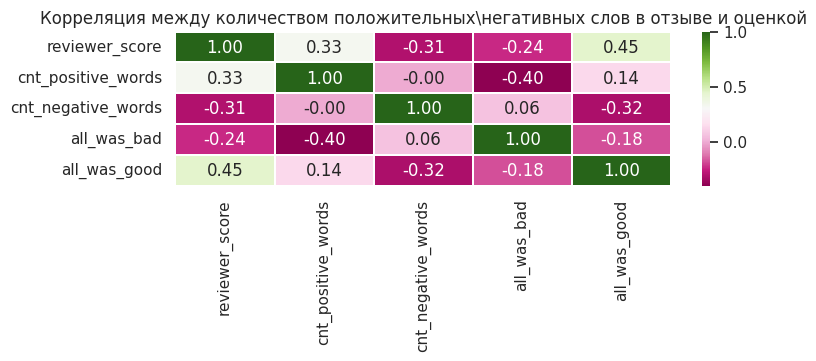

In [120]:
fig_, ax_ = plt.subplots(figsize=(8, 2))
corr = data[data['sample']==1][['reviewer_score', 'cnt_positive_words', 'cnt_negative_words', 'all_was_bad', 'all_was_good']].corr(method="spearman")
sns.heatmap(corr, 
            annot=True, 
            linewidths=0.1, 
            ax=ax_,  
            cmap='PiYG',
            fmt='.2f')
plt.title('Корреляция между количеством положительных\негативных слов в отзыве и оценкой');

In [121]:
num_col.extend(['cnt_positive_words', 'cnt_negative_words'])

2. Определяем полярность и распределяем отзывы по категориям.

In [122]:
# Теперь проанализируем полярность каждого отзыва
from textblob import TextBlob

# Функция для расчета полярности текста
def calculate_polarity(text):
    """
    Эта функция принимает текстовую строку и возвращает ее полярность.
    
    :param text: Строка с текстом, который нужно проанализировать
    :return: Полярность текста, представляющая собой число от -1 до 1
             (-1 означает полностью негативный текст, 1 — полностью позитивный)
    """
    blob = TextBlob(text)
    return round(blob.sentiment.polarity, 3)

# Применяем функцию к колонкам с отзывами
data['polarity_positive'] = data.positive_review.apply(calculate_polarity)
data['polarity_negative'] = data.negative_review.apply(calculate_polarity)

Обработаем полярность вручную.

In [123]:
data['polarity_positive'] = data.apply(lambda x: -1 if x.all_was_bad == 1 else x.polarity_positive, axis=1)
data['polarity_negative'] = data.apply(lambda x: 1 if x.all_was_good == 1 else x.polarity_negative, axis=1)

In [124]:
data['total_polarity'] = (data.polarity_positive + data.polarity_negative).round(1)


Распеределяем полярность отзывов по 3 категориям: 
* Положительные
* Нейтральные
* Негативные

In [125]:
def cat_rev(polarity):
    '''
    Определяет температуру отзыва: положительный, нейтральный, негативный
    
    Параметры:
    polarity_positive, polarity_negative (int): Уровень полярности отзыва
    
    Возвращает:
    int: Вид отзыва - (1 - позитивный), (0 - нейтральный), (-1 - негативный)
    '''
     
    if polarity > 0.5:
        return 1
    
    elif polarity <= -0.6:
        return -1
    
    else:
        return 0

# признак нейтральности отзыва
data['category_review'] = data.apply(lambda x: cat_rev(x.total_polarity), axis=1)

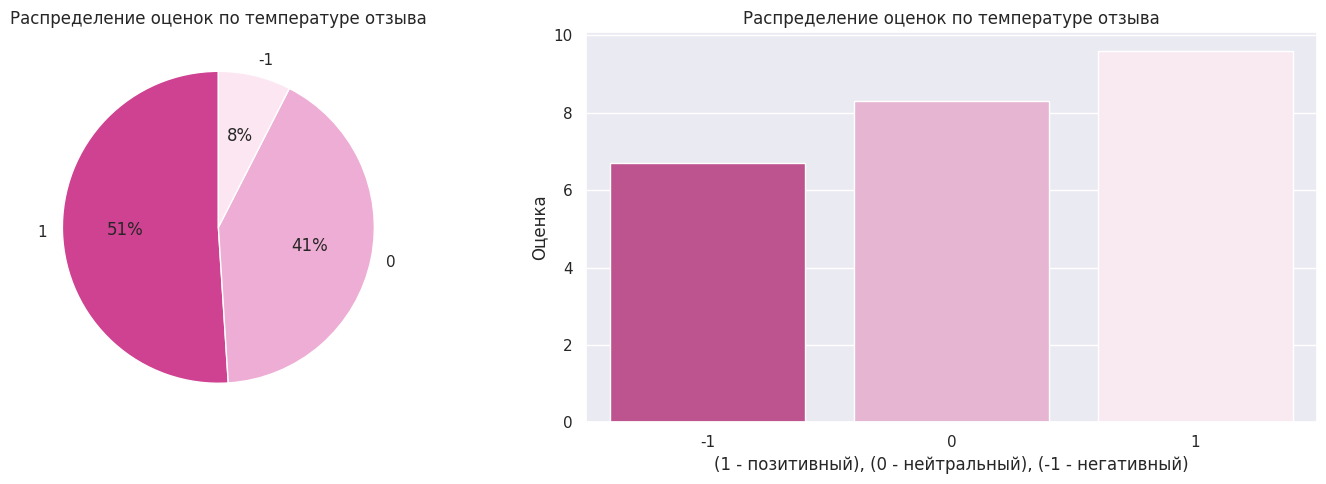

In [126]:
pie_bar('category_review', 'Распределение оценок по температуре отзыва', '(1 - позитивный), (0 - нейтральный), (-1 - негативный)')

In [127]:
pos = data.loc[(data['sample'] == 1) & (data.category_review == 1), 'reviewer_score']
not_pos = data.loc[(data['sample'] == 1) & (data.category_review == -1), 'reviewer_score']
neitr = data.loc[(data['sample'] == 1) & (data.category_review == 0), 'reviewer_score']

print(f'Медиана позитивных: {pos.median()}, \nМедина нейтральных: {neitr.median()}, \nМедиана негативных: {not_pos.median()}')

Медиана позитивных: 9.6, 
Медина нейтральных: 8.3, 
Медиана негативных: 6.7


Оценки у положительных и негативных   и нейтральных отзывов различны.

**Нулевая гипотеза:**
Оценки у положительных и негативных и нейтральных отзывов равны.

**Альтернативная гипотеза:**
Оценки у положительных и негативных   и нейтральных отзывов различны.

In [128]:
# Проводим тест Шапиро
shapiro(pos, 1)
shapiro(not_pos, 2)
shapiro(neitr, 3)

Группа 1: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 2: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 3: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 197306.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 29082.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 160415.
  res = hypotest_fun_out(*samples, **kwds)


In [129]:
stat_test('kruskal', [pos, neitr, not_pos])

print(cohens(pos, not_pos))
print(cohens(pos, neitr))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
Cohen's d: 1.7, уровень эффекта: очень большой
Cohen's d: 0.9, уровень эффекта: очень большой


In [130]:
num_col.extend(['polarity_positive', 'polarity_negative'])

In [131]:
cat_col.append('category_review')

3. Считаем по отелям количество положительных, нейтральных и негативных отзывов.

In [132]:
data[(data['sample']==1)&(data.hotel_name =='45 Park Lane Dorchester Collection')]['reviewer_score'].min()

8.3

In [133]:
# Группируем данные и считаем количество каждого типа отзывов
cnt_all_review = data.groupby(['hotel_name', 'category_review'])['full_review'].count().unstack().reset_index()
cnt_all_review.columns = ['hotel_name', 'cnt_negative', 'cnt_neitral','cnt_positive']
cnt_all_review.fillna({'cnt_neitral': 0}, inplace=True)
cnt_all_review.fillna({'cnt_negative': 0}, inplace=True)
cnt_all_review.fillna({'cnt_positive': 0}, inplace=True)


# Соединим расчет с нашим датафреймом
data = data.merge(cnt_all_review, on='hotel_name', how='left')
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,positive_review_split,negative_review_split,cnt_positive_words,polarity_positive,polarity_negative,total_polarity,category_review,cnt_negative,cnt_neitral,cnt_positive
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,leaving,1,1994,staff were amazing,...,"[staff, were, amazing]",[leaving],2,0.6,0.0,0.6,1,79.0,329.0,392.0
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,2,1361,location,...,[location],"[poor, breakfast]",1,0.0,-0.4,-0.4,0,51.0,234.0,317.0


Создадим признак, который покажет как соотносятся разница между количеством положительных отзывов и отрицательных к общему числу отзывов.

In [134]:
data['sentiment_index'] = (data['cnt_positive'] - data['cnt_negative']) / (data['cnt_positive'] + data['cnt_neitral'] + data['cnt_negative'])

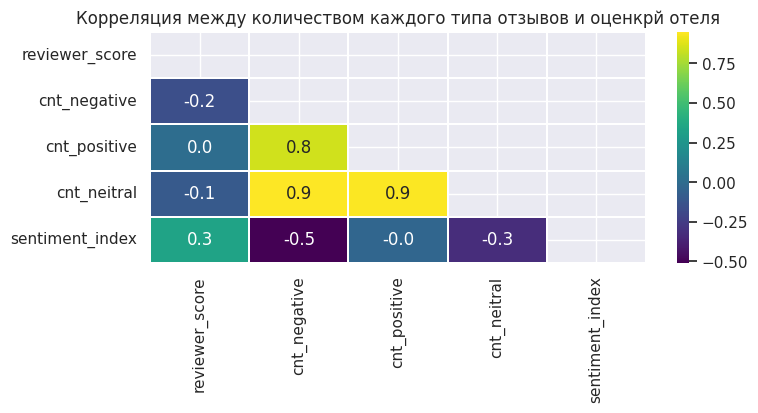

In [135]:
fig_, ax_ = plt.subplots(figsize=(8, 3))
corr = data[data['sample'] == 1][['reviewer_score', 'cnt_negative', 'cnt_positive', 'cnt_neitral', 'sentiment_index']].corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, 
            annot=True, 
            linewidths=0.1, 
            ax=ax_, 
            mask=mask, 
            cmap='viridis',
            fmt='.1f')

plt.title('Корреляция между количеством каждого типа отзывов и оценкрй отеля')
plt.show()

Оставим для обучения только признак количества негативных отзывов у отеля. У него есть более сильная обратная корреляция с оценкой отеля. Остальные признаки из-за наличия мультиколинеарности, для обучения не будем использовать.

In [136]:
num_col.extend(['cnt_negative', 'sentiment_index'])

## **Извлекаем максимальное количество полезной информации из отзывов.**

Рецензенты могли остаться довольны или недовольны слудеющими пунктами:
* Размерами комнаты
* Завтраками
* Локацией
* Персоналом
* Доп услугами
* Безопасностью
* Чистотой
* Неисправностью оборудования.

Для начала создадим функцию, которая будет находить часто встречающиеся сочетания с ключевыми словами. Так можно понять как та или иная услуга отеля воспринималась постояльцами.

In [137]:

def find_phrase(review, words):
    '''
    Функция ищет часто встречающие комбинации слов с ключевыми словами
    
    '''
    
    phrases = []
    review = re.sub(r'[^\w\s]', '', review).lower().split()  # Удаляем специальные символы и приводим к нижнему регистру

    
    for index, word in enumerate(review):
        if word in words:
            # Формирование фраз в зависимости от позиции слова
            if index == 0:
                if len(review) == 1:
                    phrases.append(' '.join(review[index:index + 2]))  # 1 слово (например, "good room")
                elif len(review) > 1:
                    phrases.append(' '.join(review[index:index + 3]))  # 2 слова (например, "good room service")
            elif index > 0:
                phrases.append(' '.join(review[index - 1:index + 1]))  # 1 предшествующее слово (например, "the good")
                if index > 1:
                    phrases.append(' '.join(review[index - 2:index + 1]))  # 2 предшествующих слова
                    phrases.append(' '.join(review[index:index + 2]))  # само слово и след. слово
                if index + 2 < len(review):
                    phrases.append(' '.join(review[index:index + 3]))  # 2 слова после
                if index + 3 < len(review):
                    phrases.append(' '.join(review[index:index + 4]))  # 2 слова после

    return phrases

words = ['location', 'place', 'located', 'center']  # Ключевые слова
# Основной блок для обработки всех отзывов
all_p = []
for review in data.positive_review:
    all_p.extend(find_phrase(review, words))

# Подсчет уникальных фраз
all_p_counts = pd.DataFrame(Counter(all_p).most_common())

In [138]:
all_p_counts[:15]

,0,1
0,the location,32751
1,great location,29766
2,location,27890
3,good location,19129
4,excellent location,11551
5,location is,8394
6,location was,7243
7,perfect location,5883
8,location and,5012
9,location for,4333


Создадим функцию для поиска ключевых фраз в отзывах.

In [139]:
# Функция для поиска ключевых слов в отзывах
def find_key_words(review_p, review_n, key_words, key_word):
    '''
    Функция ищет вхождение ключеых слов в положительных\отрицательных отзывах
    
    Параметры:
    review_p, review_n (str): положительный\отрицательный отзыв
    key_word (list): список ключевых слов
    key_word (str): слово, которое проверяется на равенство
    
    Возвращает:
    int : -1, 0, 1 в зависимости от того, остался ли доволен постоялец или нет
    '''
    
    for word in key_words:
        if word in review_p or word in review_n or 'review_p' ==  key_word:
            return 'good'
        
    if review_n == key_word:
        return 'bad'
    
    else:
        return 'neitral'  # Если не найдено ни одно ключевое слово, возвращаем 0

   * Остались ли довольны рецензенты локацией отеля.

Изучив список часто встречающихся словосочетаний относительно расположения отеля, оставила самые распостраненные.

In [140]:
# Список ключевых слов
key_words = [
    'great location', 'good location', 'excellent location', 'amazing location',
    'perfect location', 'location was great', 'location is great', 'central location',
    'location was perfect', 'location was excellent', 'location is perfect', 'a great location',
    'very good location', 'fantastic location', 'location is excellent', 'convenient location',
    'location was good', 'nice location', 'location is good', 'location location', 'well located',
    'great location', 'quiet location', 'great place', 'amazing location', 'location great',
    'a good location', 'location good', 'location excellent', 'loved the location', 'ideal location',
    'brilliant location', 'best location', 'nice place', 'superb location', 'centrally located',
    'hotel great location', 'liked the location', 'location was fantastic', 'an excellent location',
    'location very good', 'location is fantastic', 'location perfect', 'location was ideal',
    'location was amazing', 'a perfect location', 'location is superb', 'good place', 'comfortable location',
    'lovely location', 'great central location', 'location was brilliant', 'super location', 'location was superb',
    'perfectly located', 'location very nice', 'lovely place', 'very central location', 'perfect place',
    'ideally located', 'good central location', 'perfect location', 'quiet place', 'handy location', 'best location'
]


# Применяем функцию к каждому отзыву в данных
data['location'] = data.apply(lambda x: find_key_words(x.positive_review, x.negative_review, key_words, 'location'), axis=1)

# Доработаем признак
data['location'] = data.apply(lambda x: 'good' if x.positive_review in ['location', 'the location', 'location and staff', 'location staff'] else x.location, axis=1)
data['location'] = data.apply(lambda x: 'bad' if x.negative_review in ['location', 'the location', 'location and staff', 'location staff'] else x.location, axis=1)

In [141]:
# кодируем признак
encoded_df = pd.get_dummies(data['location'], prefix='location')

# Объединение с исходным DataFrame
data = pd.concat([data, encoded_df], axis=1)
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,total_polarity,category_review,cnt_negative,cnt_neitral,cnt_positive,sentiment_index,location,location_bad,location_good,location_neitral
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,leaving,1,1994,staff were amazing,...,0.6,1,79.0,329.0,392.0,0.39125,neitral,False,False,True
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,2,1361,location,...,-0.4,0,51.0,234.0,317.0,0.44186,good,False,True,False


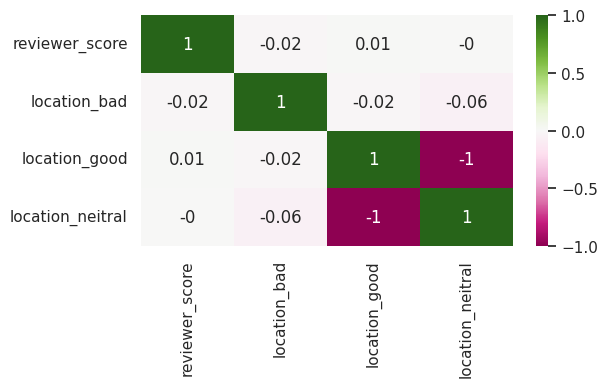

In [142]:
fig, axes = plt.subplots(figsize=(6,3))
sns.heatmap(
    data[data['sample'] == 1][['reviewer_score', 'location_bad', 'location_good', 'location_neitral']].corr(method='spearman').round(2),
    annot=True,
    cmap='PiYG');

Корреляция слишком ысокая между хорошей и нейтральной локацией, поэтому этот признак(нейтральный) не будем брать для обучения.

In [143]:
# Добавляем к категориальным признакам
cat_col.extend(['location_good', 'location_bad'])

 * Понравилось ли обслуживание в отеле

In [144]:
words = ['service', 'staff', 'reseption', 'lady', 'person']  # Ключевые слова
# Основной блок для обработки всех отзывов
all_p = []
for review in data.positive_review:
    all_p.extend(find_phrase(review, words))

# Подсчет уникальных фраз
all_p_counts = pd.DataFrame(Counter(all_p).most_common())

In [145]:
all_p_counts

,0,1
0,the staff,48786
1,friendly staff,24514
2,staff were,24396
3,staff,23841
4,helpful staff,16730
...,...,...
131682,staff are lovley the,1
131683,clean kind service,1
131684,service definitely recommendable,1
131685,service definitely recommendable accommodation,1


In [146]:
key_words = [
     'friendly staff', 'helpful staff', 'great staff', 'staff were friendly',
     'very friendly staff', 'staff very friendly', 'staff very helpful',
     'friendly staff', 'nice staff', 'excellent staff',
     'staff great', 'friendly helpful staff', 'staff good', 'staff were excellent',
     'staff friendly', 'lovely staff', 'good staff', 'excellent service', 'staff were helpful',
     'great service', 'good service', 'staff friendly', 'staff were great', 'staff was friendly',
     'staff were lovely', 'staff nice','attentive staff', 'pleasant staff', 'staff were amazing',
     'staff helpful', 'comfortable staff', 'welcoming staff', 'amazing staff', 'staff are friendly',
     'staff lovely', 'professional staff', 'efficient staff','polite staff', 'service was excellent',
     'wonderful staff', 'staff comfortable', 'staff were fantastic', 'fantastic staff', 'kind staff',
     'staff very good', 'helpful friendly staff', 'staff was helpful', 'very good staff', 'staff was excellent',
     'staff was great', 'staff is friendly', 'helpfull staff', 'staff very nice', 'staff were super',
     'courteous staff', 'comfy staff', 'friendliness of staff', 'friendly service', 'perfect staff',
     'staff were brilliant', 'excellent staff', 'staff extremely helpful', 'staff were polite',
     'super friendly staff', 'excellent customer service', 'accommodating staff', 'staff were nice',
     'staff were wonderful', 'staff was amazing', 'staff were incredibly', 'staff was super',
     'comfortable staff', 'staff very pleasant', 'good service', 'staff very polite', 'staff very attentive',
     'staff were pleasant', 'staff were exceptionally', 'staff beautiful', 'helpful reception staff',
     'staff were exceptional', 'staff amazing', 'staff really helpful', 'service great', 'staff are excellent',
     'comfortable staff','staff fantastic', 'staff very welcoming', 'staff were welcoming','staff very comfortable',
     'shuttle service', 'brilliant staff', 'friendly reception staff', 'superb staff', 'staff are amazing',
     'staff were superb', 'staff wonderful', 'amazing service', 'staff were attentive','very attentive staff',
     'staff extremely friendly', 'staff comfy', 'fantastic service', 'extremely helpful staff', 'great customer service',
     'staff polite', 'facilities staff', 'staff well','very kind staff', 'fabulous staff', 'staff pleasant',
     'very welcoming staff', 'staff were courteous', 'staff is super', 'staff brilliant', 'staff very accommodating',
     'staff friendly helpful', 'happy staff', 'staff were amazingly', 'staff convenient', 'freindly staff', 'staff were incredible',
     'staff was good', 'service was impeccable', 'comfortable friendly staff', 'like the staff', 'professional service',
     'excellent reception staff']

In [147]:
# Применяем функцию к каждому отзыву в данных
data['personal'] = data.apply(lambda x: find_key_words(x.positive_review, x.negative_review, key_words, 'staff'), axis=1)

In [148]:
data['personal'] = data.apply(lambda x: 'bad' if x.negative_review == 'location staff' or 
                                                 x.negative_review == 'the staff' or
                                                 x.negative_review == 'staff location' or 
                                                 'unhelpful' in x.negative_review or 
                                                 'unfriendly' in x.negative_review or
                                                 'rude' in x.negative_review 
                                              else x.personal, axis=1)

data['personal'] = data.apply(lambda x: 'good' if x.positive_review == 'staff' or 
                                                  x.positive_review == 'location and staff' or
                                                  x.positive_review == 'location staff' or 
                                                  x.positive_review == 'the staff' 
                                               else x.personal, axis=1)   

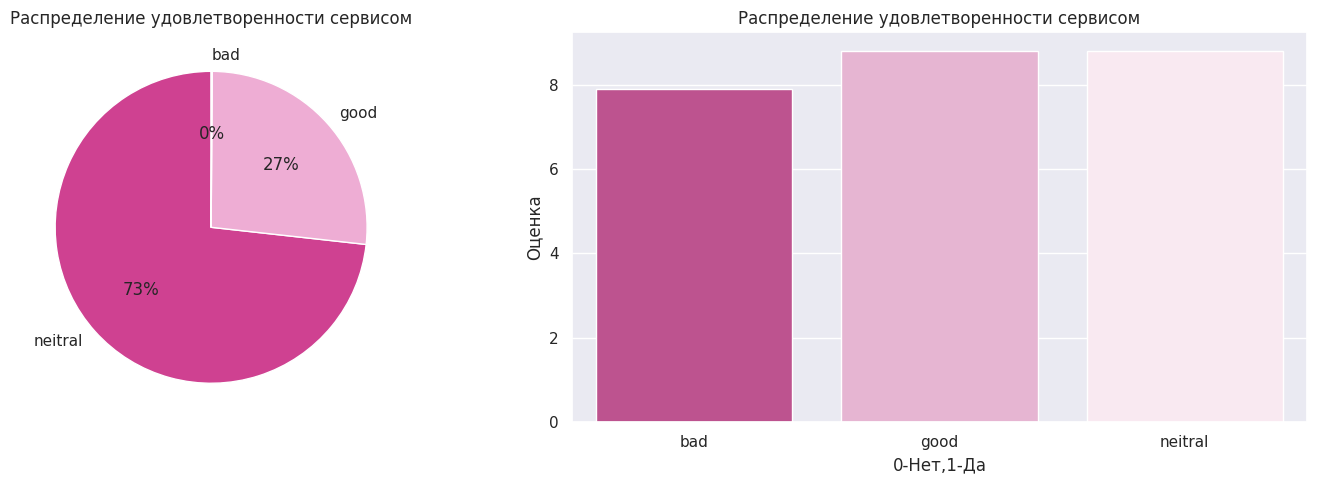

In [149]:
pie_bar('location', "Распределение удовлетворенности сервисом", '0-Нет,1-Да')

In [150]:
# кодируем признак
encoded_df = pd.get_dummies(data['personal'], prefix='personal')

# Объединение с исходным DataFrame
data = pd.concat([data, encoded_df], axis=1)
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,cnt_positive,sentiment_index,location,location_bad,location_good,location_neitral,personal,personal_bad,personal_good,personal_neitral
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,leaving,1,1994,staff were amazing,...,392.0,0.39125,neitral,False,False,True,good,False,True,False
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,2,1361,location,...,317.0,0.44186,good,False,True,False,neitral,False,False,True


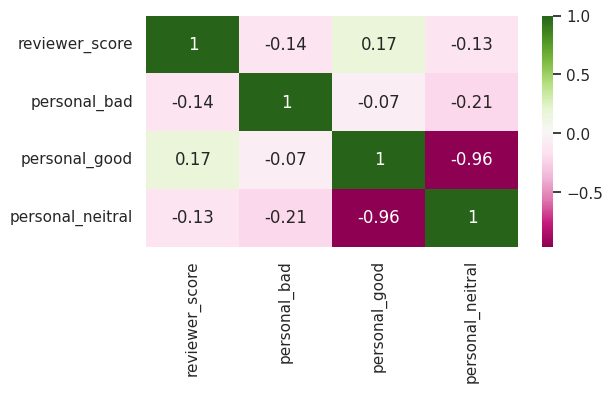

In [151]:
fig, axes = plt.subplots(figsize=(6,3))
sns.heatmap(
    data[data['sample'] == 1][['reviewer_score', 'personal_bad', 'personal_good', 'personal_neitral']].corr(method='spearman').round(2),
    annot=True,
    cmap='PiYG'
);

In [152]:
# Добавляем этот признак в список на обучение модели
cat_col.extend(['personal_bad', 'personal_good'])

   * Остались ли недовольны комнатой

In [153]:
words = ['room', 'rooms', 'bedroom', 'bathroom']  # Ключевые слова
# Основной блок для обработки всех отзывов
all_p = []
for review in data.negative_review:
    all_p.extend(find_phrase(review, words))

# Подсчет уникальных фраз
all_p_counts = pd.DataFrame(Counter(all_p).most_common())

In [154]:
all_p_counts

,0,1
0,the room,58743
1,in the room,18864
2,room was,17231
3,room,13162
4,the bathroom,12434
...,...,...
226123,rooms check in queues,1
226124,little longer room,1
226125,room was larger it,1
226126,room to shower we,1


In [155]:
key_words = [   
    'room was small', 'very small room', 'room was very small', 'room was tiny', 'tiny room',
    'superior room', 'room was a little', 'room very small', 'small bathroom','rooms are small',
    'room without winows', 'room too small', 'noisy room', 'size of room', 'very small rooms',
    'room was too small', 'room is small', 'room was cold', 't clean the room', 'little room',
    'rooms are very small', 'room temperature', 'room was small', 'rooms very small', 'room small',
    'room price', 'room is too small', 'room was smaller', 'room cleaning', 'room is very small',
    'poor room', 'tiny bathroom', 'rooms were small', 'very small bathroom', 'room was too hot',
    'room was dirty', 'room was so small', 'tiny rooms', 'rooms a little', 'room was not cleaned',
    'room staff', 'dark room', 'room was noisy', 'bathroom was tiny', 'bathroom very small', 'dirty room',
    'rooms available', 'room felt', 'bathroom was very small', 'size room', 'room view',
    'room was very warm', 'room was tiny and', 'the smallest room','room smelled', 'room was freezing',
    'rooms too small', 'room was dark', 'rooms were very small', 'room was very cold', 'little room',
    'room was very noisy', 'very noisy room', 'room wasn t cleaned', 'small bedroom', 'rooms are too small',
    'bathroom a little', 'bathroom room', 'bathroom too small', 'old rooms', 'room was old', 'uncomfortable room'
    'a tiny room', 'room was really small', 'room was not clean', 'noisy rooms', 'bathroom was a little',
    'not cleaned up', 'dusty', 'bad room', 'dirty', 'untide', 'disgusting'
]

def find_word(review_n, review_p, key_words):
    '''
    Функция ищет ключевые слова, которые характеризуют недовольство номером отеля и возвращает значение 1/0(да/нет)
    
    Принимает:
    review (str) - Негативный отзыв
    
    Возвращает:
    int - 1 или 0 (Плохая комната\ Нет информации о персонале)
    '''

    for word in key_words:
        if word in review_n.lower() or word in review_p.lower() or review_n == 'room':
            return 1
    return 0
        
# применяем функцию к столбцу
data['bad_room'] = data.apply(lambda x: find_word(x.negative_review, x.positive_review, key_words), axis=1)

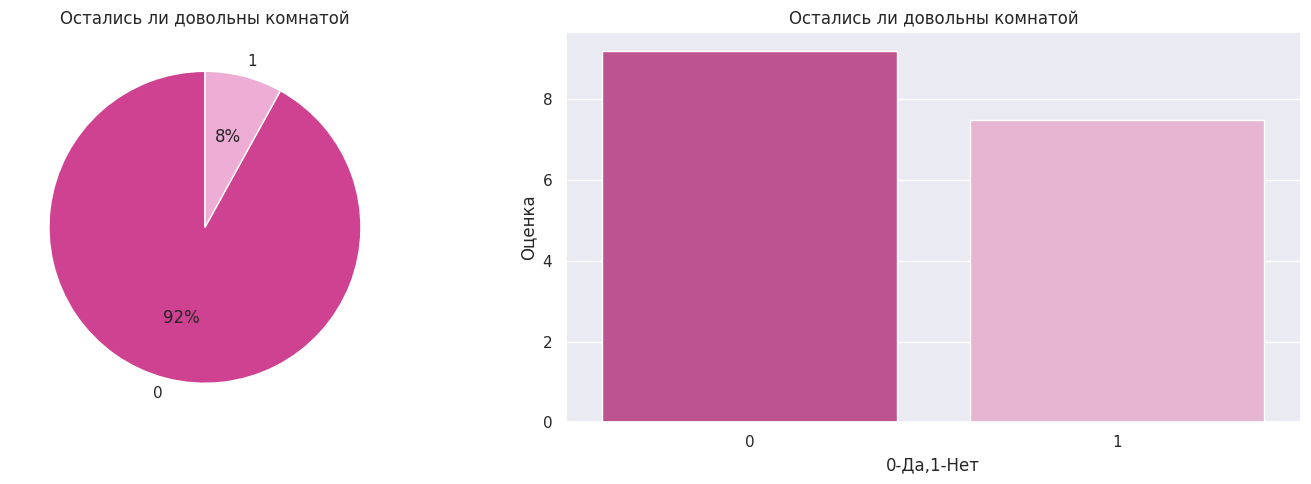

In [156]:
pie_bar('bad_room', 'Остались ли довольны комнатой', '0-Да,1-Нет')

**Нулевая гипотеза:** Рецензенты, которые остались недовольны комнатой, ставят оценки равные или выше остальных рецензентов.

**Альтернативная гипотеза:** Рецензенты, которые остались недовольны комнатой, ставят оценки ниже остальных рецензентов.


In [157]:
# Проверяем нормальность распределения
good_r = data.loc[(data['sample'] == 1) & (data['bad_room'] != 1), 'reviewer_score']
bad_r = data.loc[(data['sample'] == 1) & (data['bad_room'] == 1), 'reviewer_score']
shapiro(bad_r, 1)
shapiro(good_r, 2)

Группа 1: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 2: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 31058.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 355745.
  res = hypotest_fun_out(*samples, **kwds)


In [158]:
# Проводим тест. 2 независимых группы с числовым признаком и с распределением отличным от нормального
stat_test('mannwhitneyu', [bad_r, good_r], alt='less')
cohens(bad_r, good_r)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


"Cohen's d: 1.0, уровень эффекта: очень большой"

In [159]:
cat_col.append('bad_room')

   * Создадим признак bad_breakfast

In [160]:
words = ['breakfast', 'dinner', 'food', 'restaurant', 'bar']  # Ключевые слова
# Основной блок для обработки всех отзывов
all_p = []
for review in data.negative_review:
    all_p.extend(find_phrase(review, words))

# Подсчет уникальных фраз
all_p_counts = pd.DataFrame(Counter(all_p).most_common())

In [161]:
all_p_counts

,0,1
0,the breakfast,9892
1,the bar,6180
2,breakfast was,6136
3,breakfast,4673
4,for breakfast,4479
...,...,...
121648,small cafe bar,1
121649,bar in reception it,1
121650,breakfast additional 21,1
121651,breakfast additional 21 pounds,1


In [162]:
key_words = [
     'breakfast was not', 'poor breakfast', 'expensive breakfast', 'breakfast wasn t', 'hot food',
     'no restaurant', 'breakfast not included', 'breakfast was poor', 'breakfast was expensive',
     'breakfast is not', 'price of breakfast', 'small breakfast', 'breakfast too expensive',
     'during breakfast', 'bar prices', 'breakfast was not included', 'cost of breakfast',
     'breakfast expensive', 'breakfast was a bit', 'breakfast is expensive', 'breakfast was average',
     'breakfast was a little', 'breakfast very expensive', 'breakfast was very poor',
     'breakfast was disappointing','very expensive breakfast', 'very poor breakfast', 'price for breakfast',
     'breakfast didn t', 'breakfast is poor', 'breakfast wasn t included', 'breakfast very poor',
     'breakfast was awful', 'breakfast was very expensive', 'breakfast was overpriced', 'breakfast breakfast',
     'breakfast was terrible', 'breakfast was too expensive', 'breakfast was not good', 'expensive bar',
     'bad breakfast', 'average breakfast', 'very small breakfast',  'breakfast didn', 't include breakfast',
     'breakfast is too expensive', 'breakfast is not included', 'breakfast did not', 'food was poor',
     'bar was empty', 'expensive food', 'food is not', 'breakfast not included in','bar very expensive',
     'breakfast was not very', 'breakfast is overpriced', 'not include breakfast', 'breakfast not very',
     'cheaper breakfast', 'scanty', 'bland', 'tasteless', 'stale', 'poor', 'sparse', 'bad breakfast',
     'worse breakfast', 'expensive breakfast']

# Функция поиска ключнвых слов, относящихся к завтраку
def find_word_b(review_p, review_n, key_words):
    '''
    Функция ищет ключевые слова, которые характеризуют недовольство питанием в отеле и возвращает значение 1/0(да/нет)
    
    Принимает:
    review (str) - Негативный отзыв
    key_words (list): Ключевые слова
    
    Возвращает:
    int - 1 или 0 (Плохая еда\ Нет информации о персонале)
    '''
    
    for word in key_words:
        
        if word in review_n.lower() or review_n == 'no breakfast' or review_n == 'breakfast' or word in review_p.lower():
            return 1
    else:
        return 0
        
# применяем функцию к столбцу
data['bad_breakfast'] = data.apply(lambda x: find_word_b(x.positive_review, x.negative_review, key_words), axis=1)

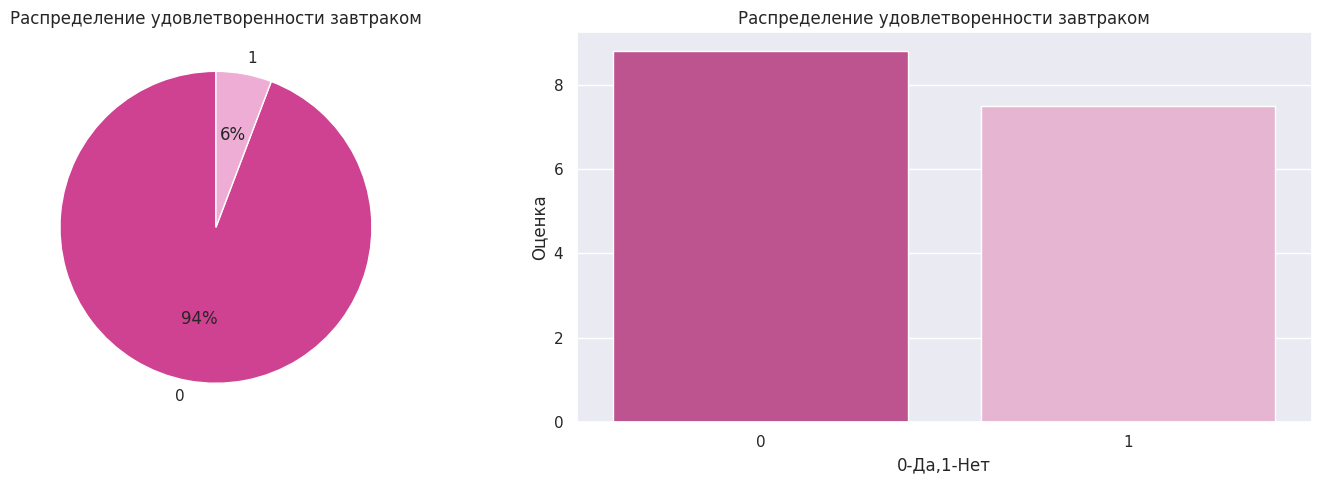

In [163]:
pie_bar('bad_breakfast', "Распределение удовлетворенности завтраком",  '0-Да,1-Нет')

Рецензенты, которые остались довольны завтраком ставят оценки выше.

**Нулевая гипотеза:** Рецензенты, которые остались довольны завтраком ставят оценки равные или ниже других рецензентов

**Альтернативня гипотеза:** Рецензенты, которые остались довольны завтраком ставят оценки выше других рецензентов

In [164]:
# Проверяем нормальность распределения

good_break = data.loc[(data['sample'] == 1) & (data['bad_breakfast'] == 0), 'reviewer_score']
bad_break = data.loc[(data['sample'] == 1) & (data['bad_breakfast'] == 1), 'reviewer_score']


shapiro(good_break, 1)
shapiro(bad_break, 2)

Группа 1: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 2: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 364487.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 22316.
  res = hypotest_fun_out(*samples, **kwds)


In [165]:
stat_test('mannwhitneyu', [good_break, bad_break], alt='greater')

cohens(good_break, bad_break)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


"Cohen's d: 0.8, уровень эффекта: большой"

In [166]:
# Добавляем признак в список для обучения

cat_col.append('bad_breakfast')

   * Довлольны ли техникой

In [167]:
words = ['wifi', 'internet', 'conditioner', 'television', 'conditioning', 'fridge']  # Ключевые слова
# Основной блок для обработки всех отзывов
all_p = []
for review in data.negative_review:
    all_p.extend(find_phrase(review, words))

# Подсчет уникальных фраз
all_p_counts = pd.DataFrame(Counter(all_p).most_common())

In [168]:
all_p_counts

,0,1
0,air conditioning,5524
1,the wifi,2172
2,the air conditioning,1717
3,free wifi,1608
4,air conditioner,945
...,...,...
35274,fridge the ac,1
35275,fridge the ac did,1
35276,internet there and,1
35277,internet there and the,1


In [169]:
key_words = [
 'no fridge', 'no air conditioning', 'no free wifi', 'poor wifi', 'mini fridge',
 'wifi was not', 'wifi didn t', 'conditioning didn t', 'conditioning was not',
 'conditioning didn t work', 'wifi is not', 'slow wifi', 'conditioning didn','wifi did not',
 'conditioning did not', 'poor internet', 'wifi didn t work','slow internet','conditioning wasn t',
 'noisy air conditioning', 'conditioning did not work', 'conditioning was not working',
 'small fridge', 'no conditioner', 'conditioning wasn', 'conditioning not working', 'wifi was poor',
 'was no fridge','bad internet','conditioning wasn t working', 'internet was not', 'very poor wifi',
 'fridge didn t','no air conditioner','no mini fridge', 'poor air conditioning', 'wifi was terrible',
 'a small fridge', 'wifi is slow', 'no free internet', 'no hair conditioner', 'conditioner was not',
 'expensive wifi', 'fridge was not', 'fridge did not','wifi was very slow','fridge no', 'fridge didn',
 'terrible wifi', 'internet speed','fridge didn t work', 'very slow internet', 'internet was slow',
 'fridge wasn t', 'very slow wifi', 'wifi very slow', 'very bad wifi', 'wifi was not working',
 'conditioner did not work', 'conditioner was not working', 'problems with wifi', 'noisy air conditioner',
 'television didn t', 'wifi is very slow', 'small wifi', 'conditioning was noisy','wifi very poor',
 'conditioning was very noisy', 'conditioning was broken', 'television did not', 'noisy fridge',
 'wifi is terrible', 'wifi not free', 'internet did not', 'fridge did not work', 'wifi is not free',
 'internet didn t', 'wifi was awful', 'internet was very slow', 'wifi was very poor',  'fridge not working',
 'was no wifi', 'unstable wifi', 'internet not', 'television didn t work', 'internet very slow',
 'wifi was horrible', 'bad air conditioning', 'wifi didnt work', 'fridge was empty', 'internet is slow',
 'little fridge', 'without air conditioning', 'weak internet', 'internet no',
 'fridge was not working', 'wifi was unstable', 'wifi is very bad', 'wifi', 'internet', 'slow']


# Функция поиска ключнвых слов, относящихся к технике
def find_word_b(review_n, key_words):
    '''
    Функция ищет ключевые слова, которые характеризуют недовольство техникой в отеле и возвращает значение 1/0(да/нет)
    
    Принимает:
    review_p, reviewer_n (str) - Негативный\позитивный отзыв
    key_words (list): Ключевые слова
    
    Возвращает:
    int - 1 или 0 (Плохая еда\ Нет информации о персонале)
    '''
    
    for word in key_words:
        
        if word in review_n.lower() or review_n == 'wifi' or review_n == 'no wifi':
            return 1
    else:
        return 0
        
# применяем функцию к столбцу
data['bad_technic'] = data.apply(lambda x: find_word_b(x.negative_review, key_words), axis=1)
# cat_col.append('bad_technic')

   * Жаловалить ли постояльцы на технику

In [170]:
data['bad_sanitary'] = data.negative_review.apply(lambda x: 1 if 'shower' in x or
                                                            'fan' in x or
                                                            'shampoo' in x or
                                                            'bathroom' in x or
                                                            'toilet' in x or
                                                            'towel' in x
                                                             else 0)
cat_col.append('bad_sanitary')

   * Жаловались ли рецензисты на дополнительные услуги

In [171]:
data['bad_additional_serv'] = data.negative_review.apply(lambda x: 1 if 'gym' in x or
                                                         'spa' in x or
                                                         'pool' in x or
                                                         'beauty salon' in x
                                                     else 0)
cat_col.append('bad_additional_serv')

In [172]:
# Функция поиска ключeвых слов, относящихся к остальным факторам, которые могли разочаровать
def find_word_other(review):
    
    words = ['parking', 'security', 'camera', 'lift', 'teapot', 'safety', 'garbage', 'smell', 'water', 'kettle', 'window']
    for i in words:
        if i in review.lower():
            return 1
    return 0
        
# применяем функцию к столбцу
data['other_bad'] = data.negative_review.apply(find_word_other)

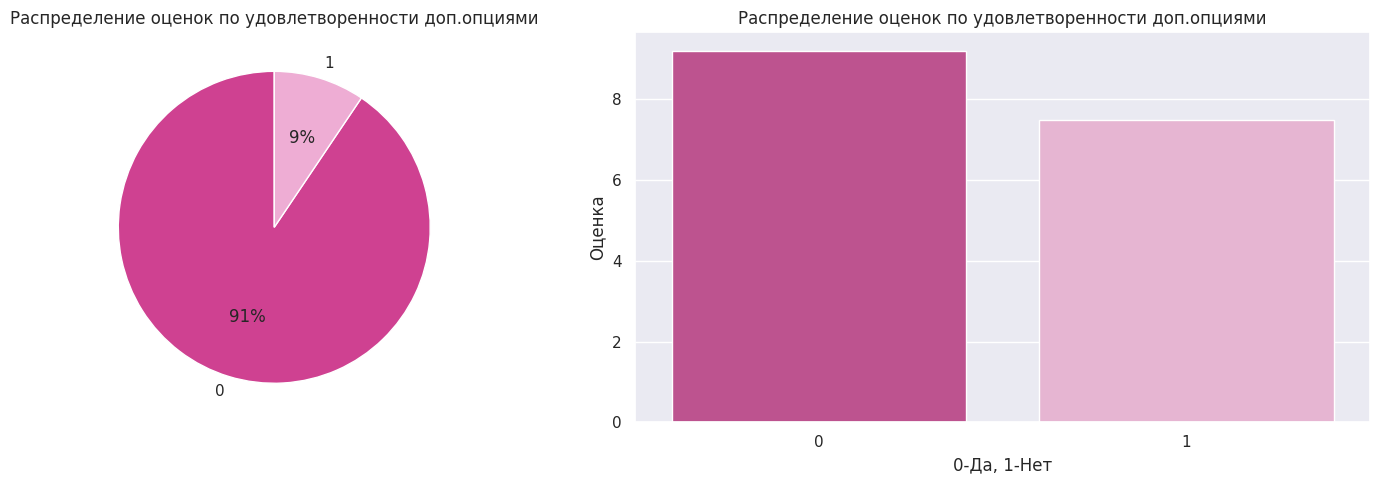

In [173]:
pie_bar('other_bad', 'Распределение оценок по удовлетворенности доп.опциями', '0-Да, 1-Нет')

Рецензенты, которые остались довольны доп опциями ставят оценки выше.

**Нулевая гипотеза:** Рецензенты, которые остались довольны доп опциями ставят оценки равные или ниже других рецензентов

**Альтернативня гипотеза:** Рецензенты, которые остались довольны доп опциями ставят оценки выше других рецензентов

In [174]:
# Проверяем нормальность распределения

good_oth = data.loc[(data['sample'] == 1) & (data['other_bad'] == 0), 'reviewer_score']
bad_oth = data.loc[(data['sample'] == 1) & (data['other_bad'] == 1), 'reviewer_score']


shapiro(good_oth, 1)
shapiro(bad_oth, 2)

Группа 1: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 2: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 350301.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 36502.
  res = hypotest_fun_out(*samples, **kwds)


In [175]:
stat_test('mannwhitneyu', [good_oth, bad_oth], alt='greater')

cohens(good_oth, bad_oth)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


"Cohen's d: 1.0, уровень эффекта: очень большой"

In [176]:
stat_test('mannwhitneyu', [good_oth, bad_oth], alt='greater')

cohens(good_oth, bad_oth)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


"Cohen's d: 1.0, уровень эффекта: очень большой"

In [177]:
cat_col.append('other_bad')

## Поработаем с датой отзыва

In [178]:
# Расчет медианного рейтинга по годам и месяцам
average_rating = data[data['sample'] == 1].groupby(['year_review', 'month_review'])['reviewer_score'].median().unstack().reset_index().fillna(0)
average_rating.columns = ['year', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
average_rating

,year,1,2,3,4,5,6,7,8,9,10,11,12
0,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.8,8.8,8.8,8.8,8.8
1,2016,9.2,9.2,9.2,8.8,8.8,8.8,8.8,8.8,8.8,8.8,8.8,8.8
2,2017,9.2,9.2,8.8,8.8,8.8,8.8,8.8,8.8,0.0,0.0,0.0,0.0


Как видно из таблицы, высокие рейтинги наблюдаются в отелях в первые 3 месяца года (январь, февраль, март). Судить можем только по последним 2 годам, так как за 2015 год информации нет.
Создадим признак, который укажет, размещен ли отзыв в эти месяцы или нет

In [179]:
data['is_first_three_month'] = data.month_review.apply(lambda x: 1 if x in [1, 2, 3] else 0)

cat_col.append('is_first_three_month')

## Признак average_score имеет туже размерность, что и клюевой признак. Поэтому оставим его как есть

In [180]:
num_col.append('average_score')

## Работаем с признаком total_number_of_reviews_reviewer_has_given

In [182]:
data['rank_h_total_number_of_reviews_reviewer_has_given'] = data.groupby('hotel_city')['total_number_of_reviews_reviewer_has_given'].rank(method='dense')
num_col.append('rank_h_total_number_of_reviews_reviewer_has_given')

## Посчитаем общую полярность отеля

In [183]:
pol = data.groupby(['hotel_name', 'category_review'])['total_polarity'].sum().round(1).reset_index()
pol.columns = ['hotel_name', 'category_review', 'polarity_hotel']
data = data.merge(pol, on=['hotel_name', 'category_review'], how='left')

num_col.append('polarity_hotel')

## Посчитаем общее количество негативных факторов для кадого отеля.

In [184]:
data['sum_of_bad'] = data.apply(lambda x: sum([x.personal_bad, x.location_bad, x.bad_room, x.bad_breakfast, x.bad_technic, x.bad_sanitary, x.bad_additional_serv, x.other_bad]), axis=1)

In [185]:
num_col.append('sum_of_bad')

## Создадим новый признак средней оценки отеля за последний месяц.

   * Считаем среднюю оценку по отелям за последний месяц

In [186]:
df = data.groupby(['hotel_name', 'year_review', 'month_review',])['reviewer_score'].mean().round(1).reset_index()
df = df.sort_values(['hotel_name','year_review', 'month_review'])
grouped = df.groupby('hotel_name').tail(1)
data = data.merge(grouped, left_on='hotel_name', right_on='hotel_name', how='left', suffixes=('', '_last_month'))

In [191]:
# Добавляемв список для обучения
num_col.extend(['reviewer_score_last_month'])

# Предпоследние шаги

## **Изучим какие признаки сильнее всего влияют на нашу целевую переменную**

In [192]:
cat_col.remove('reviewer_location')
cat_col.remove('category_review')

In [193]:
# Кодируем признаки
data = pd.get_dummies(data, columns=['reviewer_location'], prefix='reviewer_location')
data = pd.get_dummies(data, columns=['category_review'], prefix='category_review')
data = pd.get_dummies(data, columns=['hotel_city'], prefix='hotel_city')

In [194]:
cat_col.extend(['reviewer_location_1', 'reviewer_location_2',
       'reviewer_location_3', 'category_review_-1', 'category_review_0',
       'category_review_1', 'hotel_city_Amsterdam', 'hotel_city_Barcelona',
       'hotel_city_London', 'hotel_city_Milan', 'hotel_city_Paris',
       'hotel_city_Vienna'])

In [203]:
data[cat_col+num_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 70 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   sample                                             515738 non-null  int64  
 1   is_good_location                                   515738 non-null  int64  
 2   room_2 rooms                                       515738 non-null  bool   
 3   room_apartment                                     515738 non-null  bool   
 4   room_classic                                       515738 non-null  bool   
 5   room_comfort                                       515738 non-null  bool   
 6   room_deluxe                                        515738 non-null  bool   
 7   room_double room                                   515738 non-null  bool   
 8   room_duplex                                        515738 non-null  bool  

In [197]:
from sklearn.preprocessing import MinMaxScaler
# Список признаков, которые необходимо нормализовать
features_to_scale = [
    'review_total_positive_word_counts',
    'review_total_negative_word_counts',
    'rank_score_by_post_code_for_each_city',
    'rank_cnt_lower_review_by_post_code',
    'rank_cnt_upper_review_by_post_code',
    'rank_popularity_hotel',
    'rank_cnt_tags',
    'cnt_positive_words',
    'cnt_negative_words',
    'cnt_negative',
    'sentiment_index',
    'rank_h_total_number_of_reviews_reviewer_has_given',
    'polarity_hotel',
    'sum_of_bad'
]

# Создание экземпляра класса MinMaxScaler
scaler = MinMaxScaler()

# Нормализация выбранных признаков
scaled_features = scaler.fit_transform(data[features_to_scale])

# Преобразование результатов в новый датафрейм
scaled_df = pd.DataFrame(scaled_features, columns=features_to_scale)

# Замена старых признаков на нормализованные
data[features_to_scale] = scaled_df

# Изучаем корреляцию и отбираем признаки

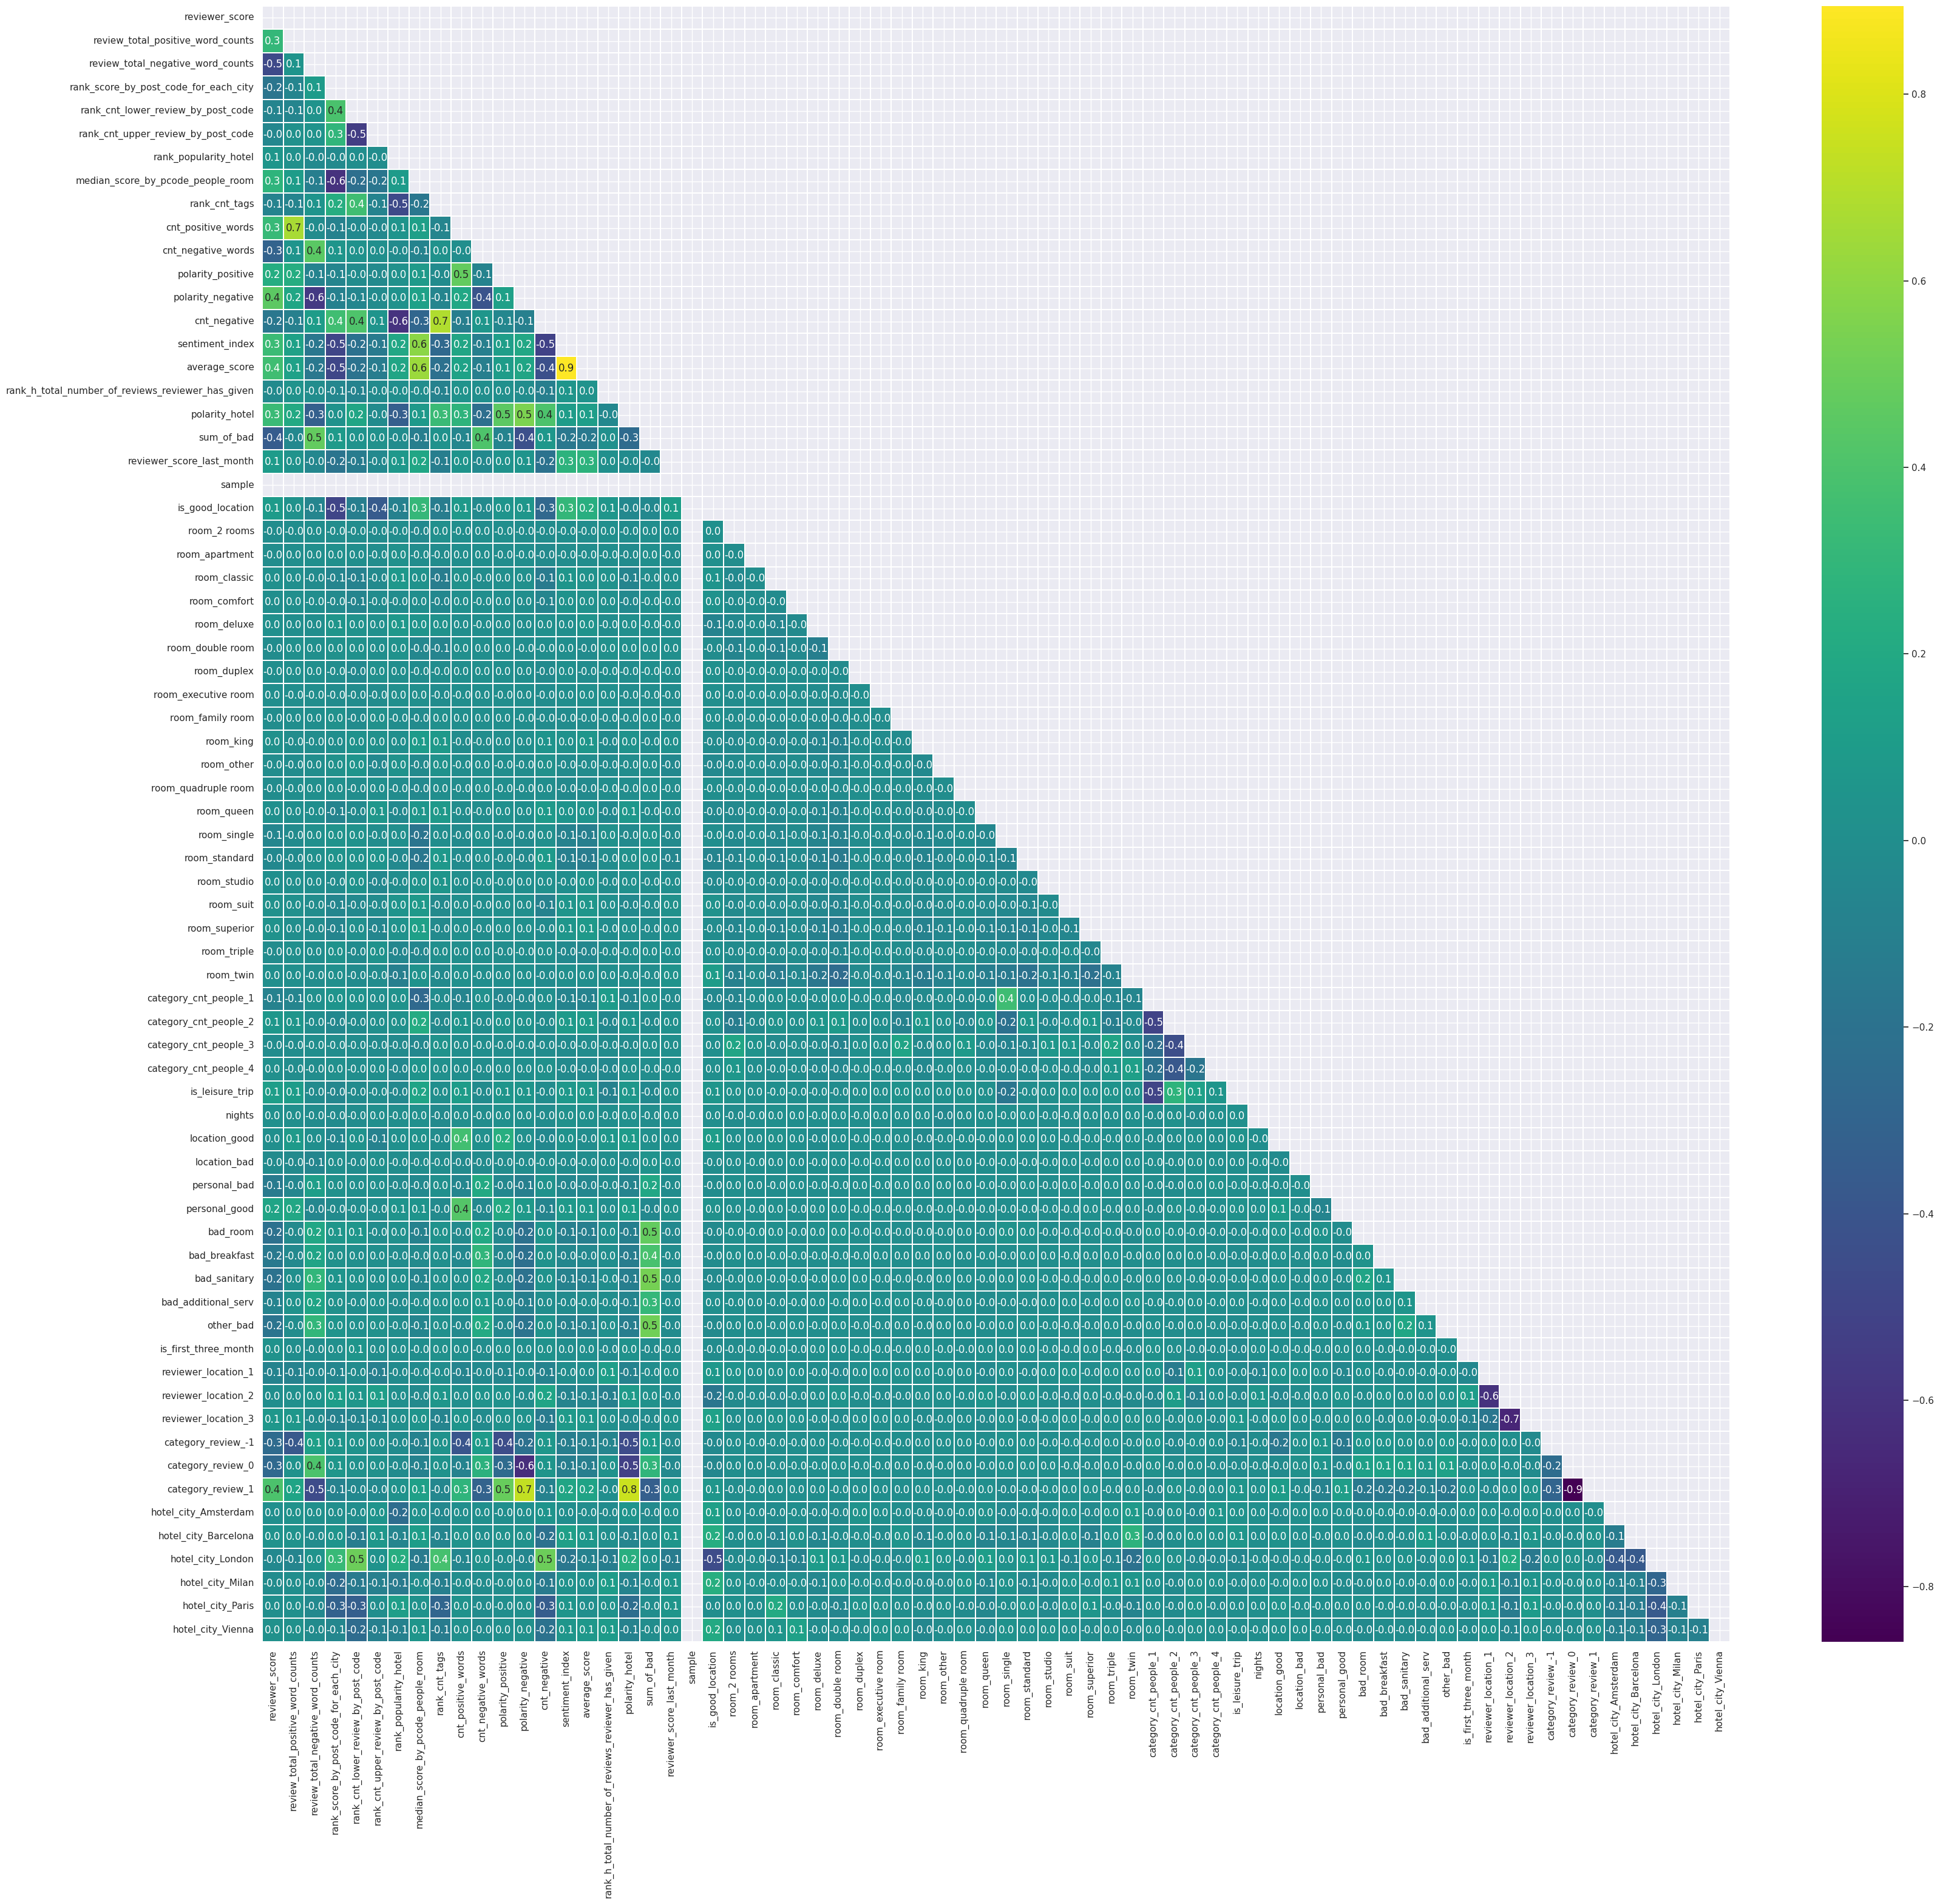

In [202]:
fig_, ax_ = plt.subplots(figsize=(39, 35))
corr = data[data['sample']==1][num_col+cat_col].corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, 
            annot=True, 
            linewidths=0.1, 
            ax=ax_, 
            mask=mask, 
            cmap='viridis',
            fmt='.1f')
plt.show()

In [204]:
cat_col.remove('category_review_1')

In [205]:
cat_cols = cat_col.copy()
cat_cols.remove('sample')

num_cols = num_col.copy()
num_cols.remove('reviewer_score')

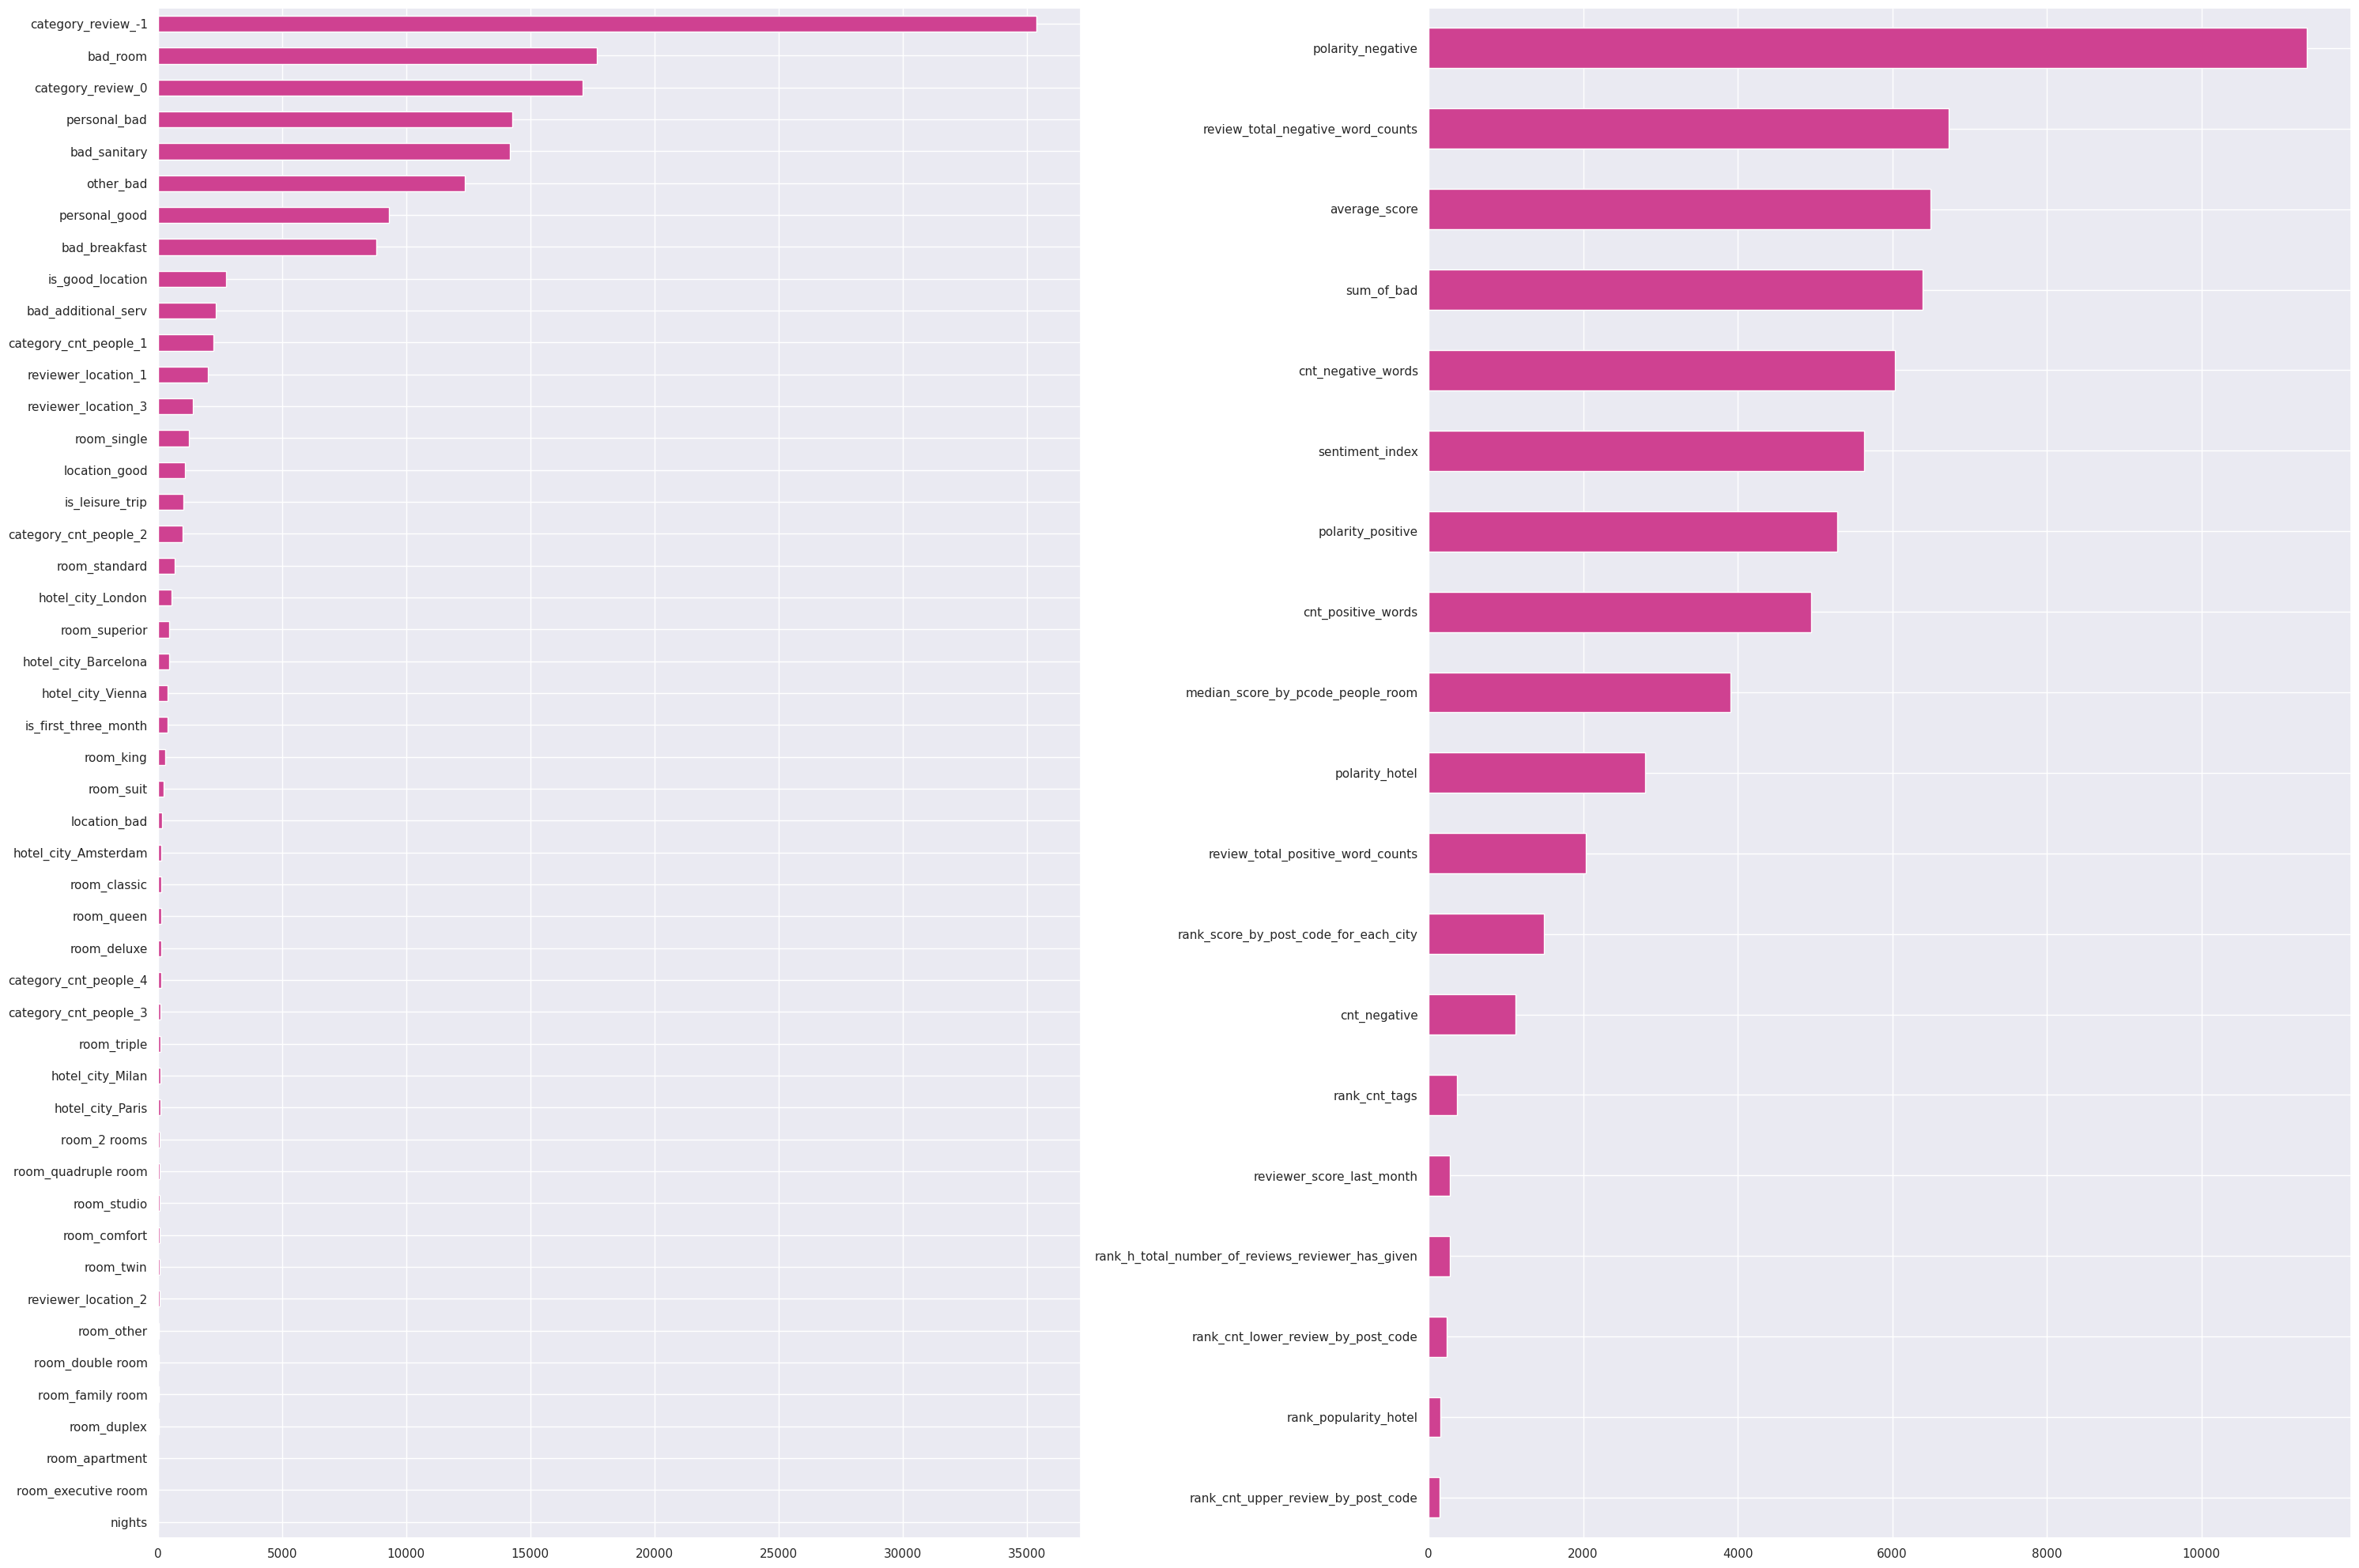

In [206]:
y=data.reviewer_score.astype('int')

imp_cat = pd.Series(chi2(data[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)

fig5, ax5 = plt.subplots(1, 2, figsize=(30, 20))
imp_cat.plot(kind = 'barh', ax=ax5[0]);

# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(data[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)

imp_num.plot(kind = 'barh', ax=ax5[1])
plt.tight_layout();

In [215]:
cat_col.remove('nights')
cat_col.remove('room_duplex')
cat_col.remove('room_executive room')
cat_col.remove('room_family room')

# **Приступаем к обучению и предсказанию!**

In [217]:
# Теперь выделим тестовую часть
train_data = data[num_col+cat_col].query('sample == 1').drop(['sample'], axis=1)
test_data = data[num_col+cat_col].query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape


((128935, 64), (386803, 64), (386803, 63), (309442, 63), (77361, 63))

In [219]:
import xgboost as xgb

# Создаем модель XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=RANDOM_SEED)

# Обучаем модель
xgb_model.fit(X_train, y_train)

# Предсказание
y_pred_xgb = xgb_model.predict(X_test)

# Вычисляем Mean Absolute Error
mae_xgb = metrics.mean_absolute_error(y_test, y_pred_xgb)
print('MAE (XGBoost):', mae_xgb)

MAE (XGBoost): 0.8398158278682668


<Axes: >

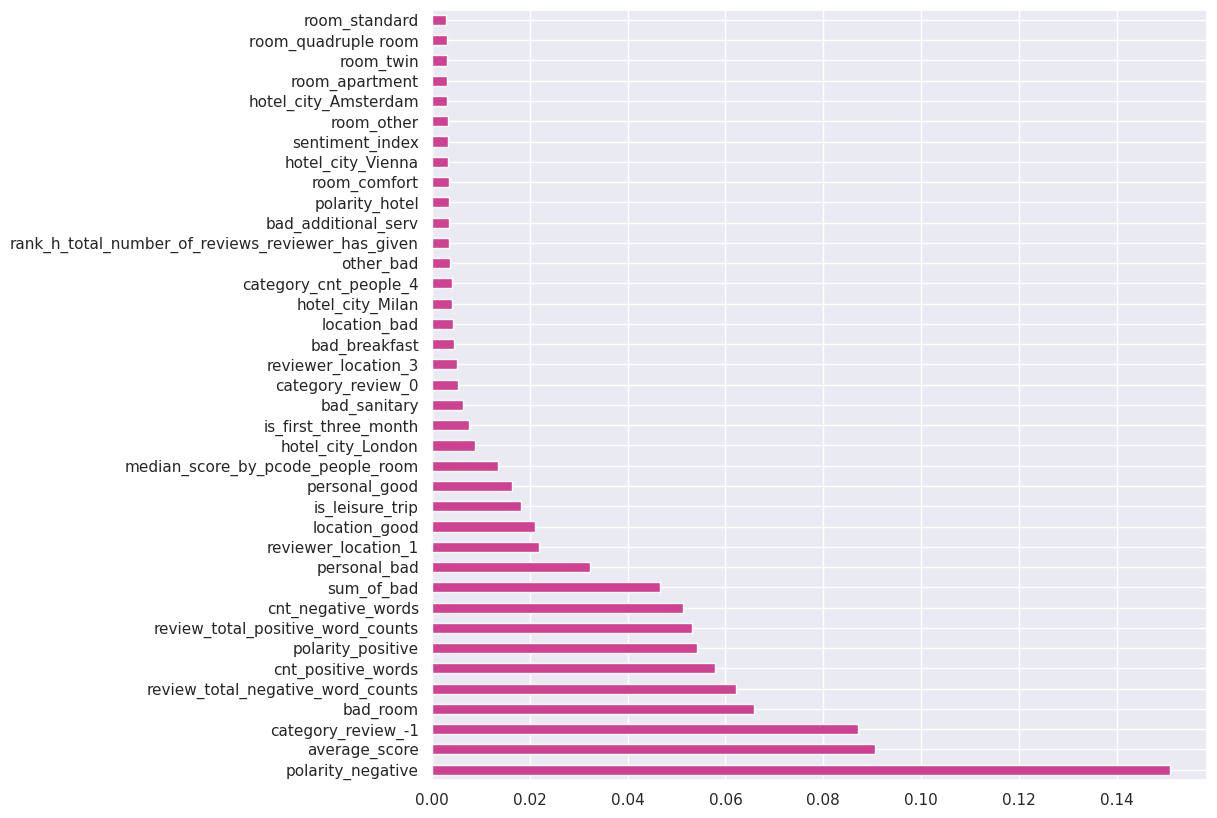

In [220]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
feat_importances.nlargest(38).plot(kind='barh')

In [ ]:
test_data

In [221]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [222]:
# Подгрузим наши данные из соревнования
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [224]:
sample_submission[:5]

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [225]:
predict_submission = xgb_model.predict(test_data)

In [226]:
predict_submission

array([8.790419 , 7.9241815, 8.554931 , ..., 8.189577 , 9.073421 ,
       7.6778264], dtype=float32)

In [227]:
list(sample_submission)

['reviewer_score', 'id']

In [228]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission[:5]

,reviewer_score,id
0,8.790419,488440
1,7.924181,274649
2,8.554931,374688
3,9.728576,404352
4,9.474011,451596
